# Tracers and barriers paper

Tracers and Barriers paper

This script is for the generation of flow model input files, running the flow model, and the generation of transport model input files & running the transport model.

THEN --> post-process the data using the post-processing (tracers_barriers_PP.py) script.

## Case Study (CS) & recharge descriptions

CS1 is with no barrier.
CS2 is fully-penetrating barrier.
CS3 is buried barrier.

Recharge 1 = Diffuse recharge across the whole aquifer.
Recharge 2 = Upgradient (mountain-front) recharge only.

## Importing packages

In [52]:
import datetime
from decimal import Decimal
import flopy
from flopy import mt3d
import flopy.utils.binaryfile as bf
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import os
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
import subprocess
import sys
import time


print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('pandas version: {}'.format(pd.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
numpy version: 1.18.1
matplotlib version: 3.1.3
pandas version: 1.0.2
flopy version: 3.3.0


## Setting up directories

In [3]:
project_folder      = os.getcwd()
print("Project folder is: %s" %project_folder)
    
dataDirectory = os.path.join(project_folder, "Data")
if not os.path.exists(dataDirectory):
    os.makedirs(dataDirectory)
    
print("The data directory is: %s" %dataDirectory)

figureDirectory = os.path.join(project_folder, "Figures")
if not os.path.exists(figureDirectory):
    os.makedirs(figureDirectory)

print("Directory to save figures: %s" %figureDirectory)

Project folder is: C:\workspace\tracers_barriers\tracers_barriers
The data directory is: C:\workspace\tracers_barriers\tracers_barriers\Data
Directory to save figures: C:\workspace\tracers_barriers\tracers_barriers\Figures


In [4]:
modelName           = "TB_01"
modelName_mt3d      = "%s_mt3d"%modelName

In [5]:
print("Flow model name is: %s, transport model name is: %s" %(modelName, modelName_mt3d))

Flow model name is: TB_01, transport model name is: TB_01_mt3d


In [6]:
MODFLOW_folder      = 'MODFLOW-NWT_64.exe'

project_folder      = os.getcwd()
MT3D_USGS_folder    = 'MT3D-USGS_64.exe'
mt3d_version        = 'mt3d-usgs' 
model_precision     = 'single' # 'double'

## Model discretisation

In [7]:
nlay = 12                    # Number of layers.
Lx = 10000.                  # Length of the model sides in metres.
Ly = 5000                    # Rectangular domain.
delr = 50.                   # Spacing length across rows in metres.
delc = delr                  # The spacing along columns and rows are equal.
ncol = int(Lx/delr)          # Number of columns.
nrow = int(Ly/delc)          # Number of rows.
ncells = nlay*ncol*nrow      # Total number of cells in the model.
ncells_per_layer = ncol*nrow # Number of cells per layer.
surface_area = Lx*Ly         # m^2

ztop = 300.                  # Top of model.
zbot = 0.                    # Base of model.
delv = (ztop - zbot) / nlay  # Length of cells in z direction.
botm = np.linspace(ztop, zbot, nlay + 1) 

print("Number of layers: %i, rows: %i, columns: %i" %(nlay, nrow, ncol))
print("Total number of cells: %i" %ncells)

Number of layers: 12, rows: 100, columns: 200
Total number of cells: 240000


# Set up figure properties

In [124]:
# Set up the extent for the plotting

extent = (delr/2., 
          Lx - delr/2., 
          delc/2., 
          Ly - delc/2.)

plt_lyr = nlay-1
row_cross_section = int(nrow/2)

fontSize = 14

def cm2inch(value):
    return value/2.54
    
mpl.rc("axes", lw=0.5, edgecolor='grey', labelsize=fontSize)
mpl.rc('lines', lw=1, c='k')
mpl.rc('font', size=fontSize)
mpl.rc('legend', labelspacing=0.1, frameon=False, fontsize=fontSize)
mpl.rc("figure", figsize=(cm2inch(8.25), cm2inch(8.25*1.25)), titlesize='medium')
mpl.rc('font',family='Arial')

colormap_options = ["gist_ncar", "RdGy_r", "gist_stern", "hsv", 
                    "nipy_spectral", 'gist_rainbow', "seismic",
                    "PiYG_r", "PuOr", "Spectral"]

contour_colors = "k"
velocity_arrows_color = "white"

head_cmap = 'coolwarm'
age_cmap = 'jet'

diff_head_cmap = colormap_options[7]
diff_age_cmap = colormap_options[6]

gamma_cmap = colormap_options[6] 
hk_array_cmap = 'Greys_r'
recharge_cmap = 'Blues'

horizontal_colour = "darkcyan"
buried_colour = "firebrick"

### Velocity arrow parameters

iskipCols = 75
iskipLayers = 2
iskipRows = 10
layerDisMultiplyer = 20
colDisMultiplyer = .8
rowDisMultiplyer = .5

## Max and min head and age for plots --> because I want them all to be 
# directly comparable, i.e. to have exactly the same colourbars

age_min = 0
age_max = 21000

head_min = 290.0
head_max = 296.0

gamma_age_min = -1.6 
gamma_age_max = 1.6

# Contour labels 

gamma_cs_labels = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
levels = np.arange(0, 20000, 5000)   # Plotting contour set
levels_2 = np.arange(0, 20000, 2500) # Plotting contour set

# Some of the contours I want to have manual plotting, but this is annoying when I
# 'm playing around with them so I can change some of them here

manual_plot = False# True/False

dpi_value = 600

## Hydraulic properties

In [9]:
sHead = 290                  # Starting head across aquifer.

sy = 0.1                     # Specific yield.
ss = sy/ztop                 # Specific storage.
laytyp = 1                   # Layer type (1 = convertible; 0 = confined).

hk_aquifer = 1.              # Hydraulic conductvity along rows (m/day).
vka = hk_aquifer/10.         # Vertical hydraulic conductivity.

prsity = sy
tortuosity_factor = 0.09

recharge_flux = 1.3699e-5    # m/d This is equivalent to 5 mm per year.
total_recharge = recharge_flux*surface_area # m^3 per day.
total_recharge_per_y = total_recharge*365.25 # m^3 per year.

length_simulation = 1        # Length of the steady-state flow model (days). 

## Barrier characteristics

This is mostly for scenarios  where barrier is orthogonal to principle groundwater flow direction (need extra in cases with angled barrier).

In [10]:
hk_barrier           = hk_aquifer/1000 # m/d 3 orders of magnitude lower than the aquifer.
barrier_width        = 50 # m
number_barrier_cols  = barrier_width/delr  # So we can test/change the grid spacing.
print("Number of barrier columns: %i" %number_barrier_cols)
column_of_barrier    = []

if number_barrier_cols == 1:
    column_of_barrier.append(int(ncol/2)) 
elif number_barrier_cols%2 == 0: # Even number
    for i in range(int(number_barrier_cols/2)):
        a = int(number_barrier_cols/2) - i
        column_of_barrier.append(int(ncol/2)-a)

    for i in range(int(number_barrier_cols/2)):
        print(i)
        column_of_barrier.append(int(ncol/2)+i)
else: # Odd number        
    for i in range(int(number_barrier_cols/2)):
        a = int(number_barrier_cols/2) - i
        column_of_barrier.append(int(ncol/2)-a)

    for i in range(int(number_barrier_cols/2)):
        print(i)
        column_of_barrier.append(int(ncol/2)+i)

    column_of_barrier.append(int(ncol/2)+int(number_barrier_cols/2))
    
percentage_gap        = 10 # CS2 
first_row_barr        = int(nrow/percentage_gap) # CS2 
last_row_barr         = int(nrow-(nrow/percentage_gap)) # CS2 
start_lay_barr        = int(nlay/2) # CS3
end_lay_barr          = nlay # CS3


middle_of_barrier = ncol/2
vol_barr_fullypen = 50*4000*300  
vol_barr_buried = 50*5000*150

sa_barr_fullypen = 50*4000 # m2
sa_barr_buried = 50*5000 # m2

xsectn_area_fp = 4000*300 # m2
xsectn_area_bu = 5000*150 # m2

len_barr_fullypen = 4000
len_barr_buried = 5000 

Number of barrier columns: 1


## Barrier characteristics - angled barrier

Calculate the nrow and ncol for the barriers with an angle. Note the coarser the grid size, the less likely length will still equal 4000 m. 

I am not sure if this script will work if `delr` $\neq$ `delc`.

### First step - define a function that will determine the number of rows and columns based on the angle.

This is the basic trigonometry: 

![title](image.png)

In [115]:
def make_angl_barr_row_cols(angle):

    print("Angle: % 2.2f" % angle)

    barr_len = len_barr_fullypen
    barr_len_across_rows = barr_len*math.cos(math.radians(angle))
    print("Barrier len across rows: %2.2f m" %barr_len_across_rows)
    barr_len_across_cols = barr_len*math.sin(math.radians(angle))
    print("Barrier len across cols: %2.2f m" %barr_len_across_cols)

    nrow_b = barr_len_across_rows/delc
    print("Number of angled barrier rows: %i" % nrow_b)
    ncol_b = barr_len_across_cols/delr
    print("Number of angled barrier cols: %i" % ncol_b)

    first_row_b = int(0+(nrow - nrow_b)/2) 
    last_row_b = int(nrow-(nrow - nrow_b)/2) 
    len_row_b = last_row_b - first_row_b 
    barr_rows_b = np.linspace(first_row_b, last_row_b, len_row_b+1)
    
    first_col_b = int((ncol/2) - (ncol_b/2))
    last_col_b = int((ncol/2) + (ncol_b/2))
    len_col_b = last_col_b - first_col_b
    barr_cols_b = np.linspace(first_col_b, last_col_b, len_col_b+1)
    
    if len(barr_rows_b) > len(barr_cols_b): 
        ratio_b = len(barr_rows_b)/len(barr_cols_b)
        dir_b = 1
        longer_len = len_row_b
        barr_rows_b = np.linspace(first_row_b, last_row_b, len_row_b+1) 
        
    elif len(barr_rows_b) == len(barr_cols_b):
        print("No changes reqd - barrier 45 degr starting rows and cols suffice")
        dir_b = 99

    else:
        ratio_b = len(barr_cols_b)/len(barr_rows_b)
        dir_b = 2
        longer_len = len_col_b 
        barr_cols_b = np.linspace(first_col_b, last_col_b, len_col_b+1)

    cols_list = []
    rows_list = []

    if dir_b == 1:    # This means that there are more rows than barriers
        for i in range(len(barr_rows_b)):
            if i % 2 == 0:
                for n in range(int(ratio_b)):
                    cols_list.append(first_col_b+i)
            else:
                for n in range(int(ratio_b+1)):
                    cols_list.append(first_col_b+i)
            barr_cols_b = cols_list[:len(barr_rows_b)]
    elif dir_b == 99:
        print("Barrier 45 degrees no update")
        
    else: # I.e. there are more columns than rows
        for i in range(len(barr_cols_b)):
            if i % 2 == 0:
                for n in range(int(ratio_b)):
                    rows_list.append(first_row_b+i)
            else:
                for n in range(int(ratio_b+1)):
                    rows_list.append(first_row_b+i)
            barr_rows_b = rows_list[:len(barr_cols_b)]

    if len(barr_cols_b) == len(barr_rows_b):
        print("Length of rows and columns of barrier are equal")
        length_barr_cells = len(barr_cols_b)
    else:
        print("Rows and columns for barrier aren't equal, you have a problem")

    #----------------------------------------
    ### Make a list of the columns the barrier is in

    #How many columns does the barrier need to be? 
    #Make sure the barrier is the correct thickness (when cell size is < barrier width).

    #This is the same for all case studies. 

    barrier_width = 50 # m
    number_barrier_cols = barrier_width/delr

    barrier_width = 50 # m
    number_barrier_cols = barrier_width/delr

    cols_barrs_list = []

    if number_barrier_cols == 1:
        cols_barrs_list.append(barr_cols_b) 

    elif number_barrier_cols%2 == 0: # Even number
        for i in range(int(number_barrier_cols/2)):
            a = int(number_barrier_cols/2) - i
            cols_barrs_list.append(np.asarray(barr_cols_b)-a)

        for i in range(int(number_barrier_cols/2)):
            print(i)
            cols_barrs_list.append(np.asarray(barr_cols_b)+i)

    else: # Odd number        
        for i in range(int(number_barrier_cols/2)):
            a = int(number_barrier_cols/2) - i
            cols_barrs_list.append(np.asarray(barr_cols_b)-a)

        for i in range(int(number_barrier_cols/2)):
            print(i)
            cols_barrs_list.append(np.asarray(barr_cols_b)+i)

        cols_barrs_list.append(np.asarray(barr_cols_b)+int(number_barrier_cols/2))

    return length_barr_cells, cols_barrs_list, barr_rows_b

## Making the hydraulic conductivity arrays

In [83]:
number_of_casestudies = 3

### Case Study 0: No barrier

In [84]:
hk_array_1 = hk_aquifer * np.ones((nlay, nrow, ncol), dtype=np.float32)      

### Case Study 1: Fully-penetrating barrier

In [85]:
hk_array_2 = hk_aquifer * np.ones((nlay, nrow, ncol), dtype=np.float32)     
  
for il in range(nlay):
    for ir in range(first_row_barr, last_row_barr, 1): 
        for col_number in range(len(column_of_barrier)):
            hk_array_2[il, ir, column_of_barrier[col_number]] = hk_barrier 

### Case Study 2: Buried barrier

In [86]:
hk_array_3 = hk_aquifer * np.ones((nlay, nrow, ncol), dtype=np.float32)     

for il in range(start_lay_barr, end_lay_barr):
    for ir in range(nrow): 
        for col_number in range(len(column_of_barrier)):
            hk_array_3[il, ir, column_of_barrier[col_number]] = hk_barrier 

### Case study 3: Angled barriers

Here I am using a function to create the HK array so it can be easily iterated over to generate each hk array for each angle.

In [116]:
def makeAngledHKArray(length_barr_cells, cols_barrs_list, barr_rows_b):

    hk_array_4_b = hk_aquifer * np.ones((nlay, nrow, ncol), dtype=np.float32)     

    for il in range(nlay):
        for i in range(length_barr_cells):
            for col_width_no in range(len(cols_barrs_list)):
                hk_array_4_b[il, int(barr_rows_b[i]), int(cols_barrs_list[col_width_no][i])] = hk_barrier 

    hk_array_4 = hk_array_4_b     
    
    return hk_array_4

In [121]:
angles = [11.25, 22.5, 33.75, 45, 56.25, 67.5, 78.75, 90]
hk_arrays_angled = []

for angle_i in range(len(angles)):
    angle = angles[angle_i]

    length_barr_cells, cols_barrs_list, barr_rows_b = make_angl_barr_row_cols(angle)
    
    
    hk_array_4 = makeAngledHKArray(length_barr_cells, cols_barrs_list, barr_rows_b)
    
    hk_arrays_angled.append(hk_array_4)   
    print("Angled array has been saved to the list")
    
print("Length of list with angled hk arrays: %i" %len(hk_arrays_angled))

Angle:  11.25
Barrier len across rows: 3923.14 m
Barrier len across cols: 780.36 m
Number of angled barrier rows: 78
Number of angled barrier cols: 15
Length of rows and columns of barrier are equal
Angled array has been saved to the list
Angle:  22.50
Barrier len across rows: 3695.52 m
Barrier len across cols: 1530.73 m
Number of angled barrier rows: 73
Number of angled barrier cols: 30
Length of rows and columns of barrier are equal
Angled array has been saved to the list
Angle:  33.75
Barrier len across rows: 3325.88 m
Barrier len across cols: 2222.28 m
Number of angled barrier rows: 66
Number of angled barrier cols: 44
Length of rows and columns of barrier are equal
Angled array has been saved to the list
Angle:  45.00
Barrier len across rows: 2828.43 m
Barrier len across cols: 2828.43 m
Number of angled barrier rows: 56
Number of angled barrier cols: 56
No changes reqd - barrier 45 degr starting rows and cols suffice
Barrier 45 degrees no update
Length of rows and columns of barri

### Plot the different hydraulic conductivity vectors

These are for the case where the barrier is oriented orthogonal to the principle groundwater flow direction.

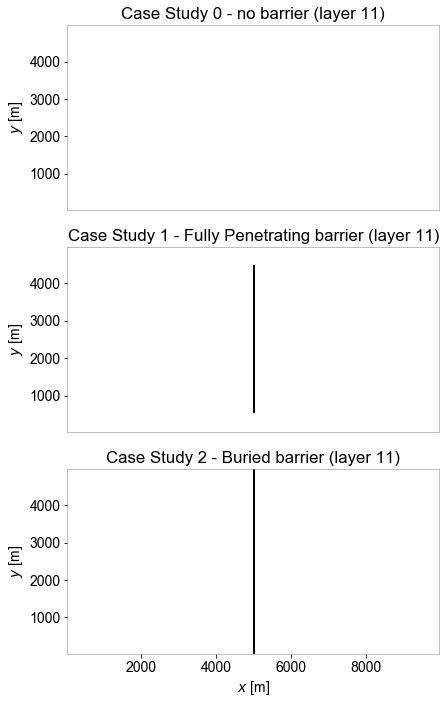

In [125]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(12,10))

ax1.imshow(np.flipud(hk_array_1[plt_lyr, :, :]), extent=extent, 
           vmin=hk_barrier, vmax=hk_aquifer, cmap=hk_array_cmap) 
ax1.get_xaxis().set_visible(False)
ax1.set_ylabel("$y$ [m]")

ax2.imshow(np.flipud(hk_array_2[plt_lyr, :, :]), extent=extent, 
           vmin=hk_barrier, vmax=hk_aquifer, cmap=hk_array_cmap) 
ax2.get_xaxis().set_visible(False)

ax2.set_ylabel("$y$ [m]")

ax3.imshow(np.flipud(hk_array_3[plt_lyr, :, :]), extent=extent, 
           vmin=hk_barrier, vmax=hk_aquifer, cmap=hk_array_cmap) 

ax3.set_ylabel("$y$ [m]")
ax3.set_xlabel("$x$ [m]")

ax1.set_title('Case Study 0 - no barrier (layer %i)' %plt_lyr)
ax2.set_title('Case Study 1 - Fully Penetrating barrier (layer %i)' %plt_lyr)
ax3.set_title('Case Study 2 - Buried barrier (layer %i)' %plt_lyr)

plt.tight_layout()

## Plot the angled hydraulic conductivity arrays

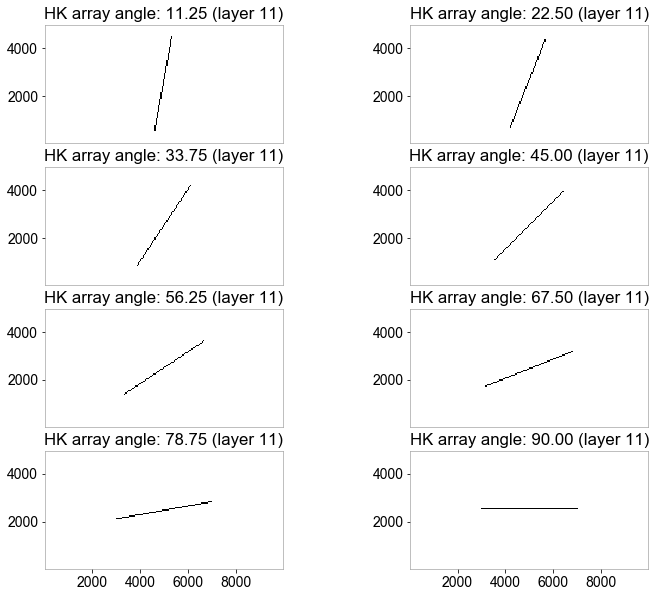

In [152]:
fig = plt.figure(figsize=(12,10))

pltcount=1
for angle_i in range(len(angles)):
    ax = plt.subplot(int(len(angles)/2), 2, pltcount)
    
    ax.imshow(np.flipud(hk_arrays_angled[angle_i][plt_lyr, :, :]), extent=extent, 
           vmin=hk_barrier, vmax=hk_aquifer, cmap=hk_array_cmap)
    
    ax.set_title('HK array angle: %2.2f (layer %i)' % (angles[angle_i], plt_lyr))

    if pltcount == int(len(angles)-1) or pltcount == int(len(angles)):
        pass
    else:
        ax.get_xaxis().set_visible(False)
    
    pltcount = pltcount+1

## Recharge characteristics

In [16]:
number_of_recharge_scenarios = 2

Recharge array 1 = diffuse recharge across the whole aquifer in equal amounts.

In [17]:
recharge_array_1 = recharge_flux * np.ones((nrow, ncol), dtype=np.float32)

Recharge array 2 = recharge across only the top of the catchment.
Recharge across all rows, across first 50 columns (One quarter of catchment).

In [18]:
n_cols_rech_2    = int(ncol/4)
n_cells_rech_2   = int(n_cols_rech_2*nrow)
SA_recharge_2    = Ly*n_cols_rech_2*delc # Surface area (m^2)
recharge_flux_2  = total_recharge/SA_recharge_2 # m/d

recharge_array_2 = np.zeros((nrow, ncol), dtype=np.float32)

for c in range(n_cols_rech_2):  # Applying recharge to every row to the columns specified.
    for r in range(nrow): 
        recharge_array_2[r, c] = recharge_flux_2

### Plot the recharge arrays

First I am going to change the units for recharge (just for the plots, not in the models.

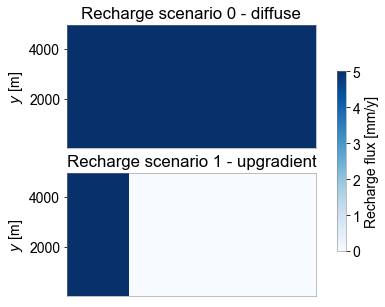

In [19]:
# Change units for the plot
conv_fact = 1000*365
recharge_ar_1_mday = np.copy(recharge_array_1)*conv_fact
recharge_ar_2_mday = np.copy(recharge_array_2)*conv_fact
rech_flux_mday = recharge_flux*conv_fact

# Now make the plots
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(6,5))

img1 = ax1.imshow(np.flipud(recharge_ar_1_mday[:, :]), extent=extent, 
           vmin=0, vmax=rech_flux_mday, cmap=recharge_cmap) 
ax1.get_xaxis().set_visible(False)
ax1.set_ylabel("$y$ [m]")

img2 = ax2.imshow(np.flipud(recharge_ar_2_mday[:, :]), extent=extent, 
           vmin=0, vmax=rech_flux_mday, cmap=recharge_cmap) 
ax2.get_xaxis().set_visible(False)

ax2.set_ylabel("$y$ [m]")
ax1.set_xlabel("$x$ [m]")

ax1.set_title('Recharge scenario 0 - diffuse')
ax2.set_title('Recharge scenario 1 - upgradient')

cbaxes1 = fig.add_axes([0.85, 0.25, 0.02, 0.5]) 
cb1 = plt.colorbar(img1, cax = cbaxes1, orientation="vertical")  
cb1.set_label('Recharge flux [mm/y]')

## Boundary conditions

General head boundary on the right-hand side.
No boundary on the left-hand side so use default condition which is a no-flow boundary.

In [20]:
stageleft  = float(sHead)
stageright = float(sHead)

bound_sp1  = []
for il in range(nlay):

    condright = (hk_aquifer * (stageright - zbot) * delc)/10

    for ir in range(nrow):
        bound_sp1.append([il, ir, ncol - 1, stageright, condright])

print('Adding ', len(bound_sp1), 'GHBs for stress period 1.')

ghb_spd = {0: bound_sp1}    

Adding  1200 GHBs for stress period 1.


Specifying starting heads

In [21]:
if nlay == 1:
    ibound = np.ones((nrow, ncol), dtype=np.int32)
    strt = sHead * np.ones((nrow, ncol), dtype=np.float32)

else:
    ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
    strt = sHead * np.ones((nlay, nrow, ncol), dtype=np.float32) 

### Plot the model set up

Text(0.5, 1.0, 'Model set up plan view for Fully Penetrating Barrier')

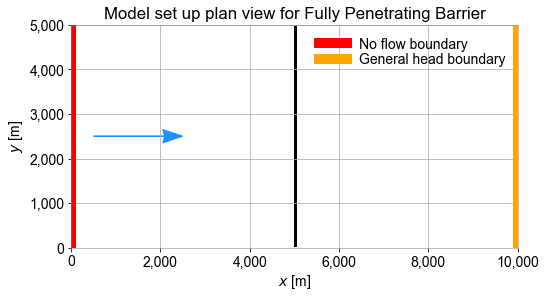

In [22]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)   

ax.imshow(np.flipud(hk_array_3[plt_lyr, :, :]), extent=extent, 
           vmin=hk_barrier, vmax=hk_aquifer, cmap=hk_array_cmap) 

ax.plot([-1,-1], [-5,-5], c="r", lw=10, label="No flow boundary")
ax.plot([-1,-1], [-5,-5], c="orange", lw=10, label="General head boundary")
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.grid()

plt.xlabel("$x$ [m]", fontsize = 14)
plt.ylabel("$y$ [m]", fontsize = 14)

ax.axvline(x=0, ymin=0, ymax=1, lw=10, color="r") 
ax.axvline(x=Lx, ymin=0, ymax=1, lw=10, color="orange")

plt.xlim([0, Lx])
plt.ylim([0, Ly])

plt.arrow(500, 2500, 2000, 0, color="dodgerblue", ls="-", lw=1, head_width=300, 
          overhang=.1, length_includes_head=True)

plt.legend(frameon=False)

ax.set_title('Model set up plan view for Fully Penetrating Barrier')


## Stress periods

1 Stress period: steady state only 

In [23]:
nper   = 1 # Number of model stress periods.
perlen = [length_simulation] 

nstp   = [1] # Number of time steps in each stress period.
tsmult = [1]
steady = [True] # True = steady state.

print("One steady-state stress periods set up")

One steady-state stress periods set up


## Input files and running flow model

Running multiple model scenarios:
         
* 1st:   Different recharge scenarios.
     
* 2nd:   Different case studies, representing the different hydraulic conductivities (barrier configurations).


In [24]:
print("The total number of scenarios is: %s" %(
                        number_of_recharge_scenarios*number_of_casestudies))

The total number of scenarios is: 6


## Function to set up and run the flow model

Need to be careful whether I am adding 1 to recharge scenario and case study or not, I have changed things around a bit. 

In [25]:
print(modelName_mt3d)

TB_01_mt3d


In [154]:
def flow_model(rechargeScenario, caseStudy):
    
    modelname = str(modelName) + "_R" + str(rechargeScenario) + "_CS" + str(caseStudy)
    print("Flow model name: " + str(modelname))
        
    modelname_mt3d = modelName_mt3d + "_R" + str(rechargeScenario) + "_CS" + str(caseStudy)
    print("Transport model name: " + str(modelname_mt3d))
    
    mf = flopy.modflow.Modflow(modelname, exe_name=MODFLOW_folder, version='mfnwt') # MODFLOW-NWT
    
    dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, 
                                        delc=delc,top=ztop, botm=botm[1:],
                                        tsmult = tsmult, nper=nper, perlen=perlen, 
                                        nstp=nstp, steady=steady)
        
    print("Discretisation module set up")
       
    # Which hydraulic conductivity array do I use, depending on which scenario is applied:
        
    if caseStudy == 0:
        hk_array = hk_array_1
        print("Setting up hk array for Case Study 0")
            
    elif caseStudy == 1:
        hk_array = hk_array_2
        print("Setting up hk array for Case Study 1")
                   
    elif caseStudy == 2:
        hk_array = hk_array_3
        print("Setting up hk array for Case Study 2")
        
    elif caseStudy == 3:
        hk_array = hk_array_4
        print("Setting up hk array for Case Study 3")
        
    else:
        print("This case study is not a viable option, choose a value from 1 to 4")
    
    uwp = flopy.modflow.mfupw.ModflowUpw(mf, hk=hk_array, vka=vka, sy=sy, ss=ss, ipakcb=53, iphdry = 53,
                                                 laytyp=laytyp) # MODFLOW- NWT
    print("Upstream weighting package set up")
        
    # --- Solver --- #
            
    nwt = flopy.modflow.mfnwt.ModflowNwt(mf, headtol=1e-05, maxiterout=200, 
                        thickfact=1e-07, linmeth=2, iprnwt=1, ibotav=1, options='SPECIFIED', 
                        Continue=True, dbdtheta=0.9, dbdkappa=1e-05, dbdgamma=0.0, momfact=0.1, 
                        backflag=1, maxbackiter=30, backtol=1.05, backreduce=0.9, maxitinner=50, 
                        ilumethod=2, levfill=5, stoptol=1e-10, msdr=15, iacl=2, norder=1, level=3, 
                        north=7, iredsys=1, rrctols=0.0, idroptol=1, epsrn=0.0001, 
                        hclosexmd=0.0001, mxiterxmd=200) # MODFLOW- NWT fluxtol=1e-3, 
                                                   
    print("Newton solver set up")
        
    # --- Recharge --- #
        
    if rechargeScenario == 0:
        recharge_array = recharge_array_1
        print("Setting up recharge array for Recharge Scenario 1")
    
    elif rechargeScenario == 1:
        recharge_array = recharge_array_2
        print("Setting up recharge array for Recharge Scenario 2")

    else:
        print("This Recharge Scenario is not a viable option, choose a value from 1 to 2")
    
    rch = flopy.modflow.ModflowRch(mf, rech=recharge_array)
        
    print("Recharge package set up")
        
    # --- General head boundaries --- #
        
    ghb = flopy.modflow.ModflowGhb(mf, stress_period_data=ghb_spd)
        
    print("General head boundary package set up")
        
    # --- SETTING UP THE OUTPUT CONTROL --- #
        
    spd = {}
    for strsp in range(nper):
        tmstp = nstp[strsp]
        for t in range(tmstp):
            spd[strsp, t] = ['save budget', 'print budget', 'save head'] 
                                       
    oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)
        
    print("Output control package set up")
        
    # --- SETTING UP BASIC PACKAGE, IBOUND --- #
        
    bas = flopy.modflow.ModflowBas(mf, ibound=1., strt=float(sHead), 
                                       ifrefm=True, ixsec=False, hnoflo=-999.99)
        
    print("Basic package set up") 
        
    # --- LINKING FILE --- #
        
    # Set up the linking file for output from flow model to be used in transport model
    lmt = flopy.modflow.ModflowLmt(mf, output_file_name= (modelname + str('_mt3dLink.ftl')),
                                       output_file_header='extended',
                                       output_file_format='unformatted')   
                                        
    print("Link-Mass Transport package set up") 
        
    # --- NOW I NEED TO COMPILE AND WRITE ALL OF THE INPUT FILES --- #
          
    mf.write_input() # Write the model input files
           
    print("Input written")
        
    # Setting up subprocess AND RUNNING THE MODEL
    #---------------------------------------------------------------
    p = subprocess.Popen([MODFLOW_folder, modelname], shell = False)   
    p.wait()
    #---------------------------------------------------------------
    print("END: Flow model has been run")
    
    return modelname, modelname_mt3d, mf
     

## Running the flow model

Just a test, running one model at a time. I will run them all below.

In [27]:
t1 = time.time()  
modelname, modelname_mt3d, mf = flow_model(0, 0)
t2 = time.time()  
run_time = t2-t1      
print("Flow model run time: " + str(run_time) + "seconds") 

Flow model name: TB_01_R0_CS0
Transport model name: TB_01_mt3d_R0_CS0
Discretisation module set up
Setting up hk array for Case Study 1
Upstream weighting package set up
Newton solver set up
Setting up recharge array for Recharge Scenario 1
Recharge package set up
General head boundary package set up
Output control package set up
Basic package set up
Link-Mass Transport package set up
Input written
END: Flow model has been run
Total run time: 8.146490573883057seconds


# Function to set up and run transport file

In [28]:
print("Modflow model details: %s" %mf)
print("Modflow model name is: %s" %modelname)
print("Mt3d model name is: %s"%modelname_mt3d)
print("MT3D executable is: %s" %MT3D_USGS_folder)

Modflow model details: MODFLOW 12 layer(s) 100 row(s) 200 column(s) 1 stress period(s)
Modflow model name is: TB_01_R0_CS0
Mt3d model name is: TB_01_mt3d_R0_CS0
MT3D executable is: MT3D-USGS_64.exe


In [29]:
def transport_model(modelname, modelname_mt3d, mf):   

    mt = mt3d.Mt3dms(modflowmodel=mf, modelname=modelname_mt3d, model_ws=project_folder, 
                         version=mt3d_version, namefile_ext='mtnam', exe_name=MT3D_USGS_folder,  
                         ftlfilename=(modelname + str('_mt3dLink.ftl'))) 
               
    #------------------------------------------------------------------------------
    # BASIC TRANSPORT PACKAGE
        
    ncomp = 1         # Total number of chemical species in simulation.  
    mcomp = 1         # Total number of "mobile" species. 
    sconc= np.zeros((nlay, nrow, ncol), dtype=np.float32)  # initial conc. = 0 yrs   
    nprs = 0          # Flag indicating frequency of output. = 0: results not saved except 
                      # at end of simulation; > 0: saved at times specified by timprs; < 0: saved
                      # whenever the  number of transport steps is an even multiple of nprs.
        
    btn = mt3d.Mt3dBtn(mt, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper, perlen=perlen, 
                           ncomp=ncomp, mcomp=mcomp, sconc=sconc, prsity=prsity,
                           delr=delr, delc=delc, icbund=1, ifmtcn=-1, savucn=True,
                           nprs=nprs, nprobs=1, cinact=0, ssflag='SState', laycon=1) 
        
    #------------------------------------------------------------------------------
    # ADVECTION PACKAGE
        
    adv = mt3d.Mt3dAdv(mt, mixelm=0)  
        
    # mixelm = 0 means that I am using the standard finite-difference method with upstream or 
    # central-in-stream weighting, depending on the value of NADVFD. 
    # Other options, MOC (1); MMOC (2); HMOC (3); TVD (-1). 
        
    #------------------------------------------------------------------------------
    # GENERALISED CONJUGATE GRADIENT SOLVER for MT3D-USGS
        
    gcg = mt3d.Mt3dGcg(mt, mxiter=30, iter1=50, isolve=2, accl=1, cclose=1e-06)
        
    #------------------------------------------------------------------------------
    # REACTION PACKAGE
        
    rc1 = np.zeros((nlay, nrow, ncol), dtype=np.float32)
    rc1[:, :, :] = -1/365.25
        
    isothm = 0      # 0 = no sorption.
    ireact = 100    # 100 = zeroth-order reaction option.
    rc1 = rc1       # First order reaction rate for diffolved phase of first species.
        
    rct= mt3d.Mt3dRct(mt, isothm=isothm, ireact=ireact, igetsc=0, rc1=rc1) 
        
    #------------------------------------------------------------------------------
    # SOURCE-SINK MIXING PACKAGE
        
    crch = np.zeros((nrow, ncol), dtype=np.float32) # The age of recharging water is 0
        
    itype = mt3d.Mt3dSsm.itype_dict()
       
    ssm = mt3d.Mt3dSsm(mt, crch=crch) #, stress_period_data=ssm_data) 
        
    #------------------------------------------------------------------------------
    # DISPERSION PACKAGE 
    al = 1.5 # The longitudinal dispersivity, default = 0.01

#   trpt = 0.1  #ratio of horizontal transverse: longitudinal dispersivity, default = 0.1
#   trpv = 0.01 #ratio of vertical transverse dispersivity: longitudinal dispersivity, default = 0.01
    dmcoef = 1E-4*tortuosity_factor # Effective molecular diffusion coefficient (for water in my model), default = 1E-9 m2/s
        
    # Instantiate up the Dispersion package for MT3D-USGS
    dsp = mt3d.Mt3dDsp(mt, al=al, dmcoef=dmcoef) 
        
    #----- WRITING transport MODEL ------------------------------------------------
         
    mt.write_input()
       
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
    # "Manual" changes to the input files
    conc_filename_dissolved = str(modelname_mt3d) + ".ucn"
    conc_filename_sorbed = str(modelname_mt3d) + "_S.ucn"
    mass_filename = str(modelname_mt3d) + ".mas"
    cnf_filename = str(modelname_mt3d) + ".cnf"
        
    ##Add a line to the MT3D .mtnam file re-naming output UCN file + MAS,CNF
    mt_name_file = modelname_mt3d + str('.mtnam')
        
    namfile = open(mt_name_file, 'a')
    namfile.write('data(binary) 201 %s \n' %(conc_filename_dissolved))
    namfile.close()
        
    namfile = open(mt_name_file, 'a')
    namfile.write('data(binary) 301 %s \n' %(conc_filename_sorbed))
    namfile.close()
              
    namfile = open(mt_name_file, 'a')
    namfile.write('data 601 %s \n' %(mass_filename))
    namfile.close()
        
    namfile = open(mt_name_file, 'a')
    namfile.write('data 17 %s \n' %(cnf_filename))
    namfile.close()
                
    ###For USGS need to add DRYCELL keyword to the .btn file on line 3
    mt_btn_file = modelname_mt3d + str('.btn')
        

    btnfile = open(mt_btn_file, "r")
    contents = btnfile.readlines()
    btnfile.close()
    contents.insert(2, "DRYCELL \n")
    btnfile = open(mt_btn_file, "w")
    contents = "".join(contents)
    btnfile.write(contents)
    btnfile.close()
        
    # ADD SSTATE FLAG manually in correct spot

    fpath = os.path.join(project_folder, mt_btn_file)
    with open(mt_btn_file, 'r+') as f:
        lines = f.readlines()
        f.seek(0)
        f.truncate()

        a = '%.1E' % Decimal(length_simulation)
        if length_simulation == 1:
            b = "1         1         1 S"
            c = "1         1         1         SState"
        else:
            b = str(a) + "         1         1 S"
            c = str(a) + "         1         1         SState"

        ##

        for line in lines:
            if b in line:
                            line = line.replace(b, c)
            f.write(line)
            
    # Running the transport model
    #--------------------------------
    success, buff = mt.run_model()
    print("Transport model has been run")
    #-------------------------------- 
        
    return mt

## Running the transport model

Again just a test, running one model at a time. I will run them all below.

In [30]:
print(mf)
print(modelname)
print(modelname_mt3d)

MODFLOW 12 layer(s) 100 row(s) 200 column(s) 1 stress period(s)
TB_01_R0_CS0
TB_01_mt3d_R0_CS0


In [31]:
t1 = time.time()
mt = transport_model(modelname, modelname_mt3d, mf)
t2 = time.time()  
run_time = t2-t1      
print("Transport model run time: " + str(run_time) + "seconds") 

FloPy is using the following  executable to run the model: C:\Program Files\mt3d-usgs_Distribution\bin\MT3D-USGS_64.exe

 MT3D-USGS - Modular 3D Multi-Species Transport Model [Ver 1.00.00] 
 and based on MT3DMS. MT3D-USGS developed in cooperation by 
 S.S. Papadopulos & Associates and the U.S. Geological Survey

 Using NAME File: TB_01_mt3d_R0_CS0.mtnam

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    1.0000    

 Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1.0000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3286E+05  [K,I,J]   12  100    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5029E+05  [K,I,J]   12  100    1
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6234E+05  [K,I,J]   12  100    1
 Outer Iter.  1  Inner Iter.  4:  Max. DC =   6351.      [K,I,J]   12   99  169
 Outer Iter.  1  Inner Iter.  5:  Max. DC =   1504.      [K,I,J]   12   98  200
 Outer Iter.  1  Inner Iter.  6:  Max. DC =   2466.      [K,I,J]   12   97

# Running all case studies

In [32]:
t1 = time.time()
for rechargeScenario in range(number_of_recharge_scenarios): # number_of_recharge_scenarios
    print("Recharge scenario: " + str(rechargeScenario))
    
    for caseStudy in range(number_of_casestudies): # number_of_casestudies
        print("Case study: " + str(caseStudy))

        modelname, modelname_mt3d, mf = flow_model(rechargeScenario, caseStudy)
        mt = transport_model(modelname, modelname_mt3d, mf)

print("Finished running all scenarios")
t2 = time.time()  
run_time = t2-t1      
print("Total run time: " + str(run_time) + "seconds") 

Recharge scenario: 0
Case study: 0
Flow model name: TB_01_R0_CS0
Transport model name: TB_01_mt3d_R0_CS0
Discretisation module set up
Setting up hk array for Case Study 1
Upstream weighting package set up
Newton solver set up
Setting up recharge array for Recharge Scenario 1
Recharge package set up
General head boundary package set up
Output control package set up
Basic package set up
Link-Mass Transport package set up
Input written
END: Flow model has been run
FloPy is using the following  executable to run the model: C:\Program Files\mt3d-usgs_Distribution\bin\MT3D-USGS_64.exe

 MT3D-USGS - Modular 3D Multi-Species Transport Model [Ver 1.00.00] 
 and based on MT3DMS. MT3D-USGS developed in cooperation by 
 S.S. Papadopulos & Associates and the U.S. Geological Survey

 Using NAME File: TB_01_mt3d_R0_CS0.mtnam

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    1.0000    

 Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1.0000    
 Outer I

 Outer Iter.  1  Inner Iter. 39:  Max. DC =  0.6274E+07  [K,I,J]   12   69  109
 Outer Iter.  1  Inner Iter. 40:  Max. DC =  0.3101E+07  [K,I,J]   12   69  109
 Outer Iter.  1  Inner Iter. 41:  Max. DC =  0.1853E+07  [K,I,J]   12   68  109
 Outer Iter.  1  Inner Iter. 42:  Max. DC =  0.7088E+07  [K,I,J]   12   67  110
 Outer Iter.  1  Inner Iter. 43:  Max. DC =  0.4449E+07  [K,I,J]   12   67  110
 Outer Iter.  1  Inner Iter. 44:  Max. DC =  0.3001E+07  [K,I,J]   12   68  112
 Outer Iter.  1  Inner Iter. 45:  Max. DC =  0.9387E+06  [K,I,J]   12   68  110
 Outer Iter.  1  Inner Iter. 46:  Max. DC =  0.6476E+07  [K,I,J]   12   66  111
 Outer Iter.  1  Inner Iter. 47:  Max. DC =  0.1999E+07  [K,I,J]   12   67  112
 Outer Iter.  1  Inner Iter. 48:  Max. DC =  0.2898E+08  [K,I,J]   12   68  110
 Outer Iter.  1  Inner Iter. 49:  Max. DC =  0.3021E+08  [K,I,J]   12   68  110
 Outer Iter.  1  Inner Iter. 50:  Max. DC =  0.5604E+06  [K,I,J]   12   67  110
 Outer Iter.  2  Inner Iter.  1:  Max. D


 Program completed.   Total CPU time:  000 minutes  4.469 seconds
Transport model has been run
Case study: 2
Flow model name: TB_01_R0_CS2
Transport model name: TB_01_mt3d_R0_CS2
Discretisation module set up
Setting up hk array for Case Study 3
Upstream weighting package set up
Newton solver set up
Setting up recharge array for Recharge Scenario 1
Recharge package set up
General head boundary package set up
Output control package set up
Basic package set up
Link-Mass Transport package set up
Input written
END: Flow model has been run
FloPy is using the following  executable to run the model: C:\Program Files\mt3d-usgs_Distribution\bin\MT3D-USGS_64.exe

 MT3D-USGS - Modular 3D Multi-Species Transport Model [Ver 1.00.00] 
 and based on MT3DMS. MT3D-USGS developed in cooperation by 
 S.S. Papadopulos & Associates and the U.S. Geological Survey

 Using NAME File: TB_01_mt3d_R0_CS2.mtnam

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    1.0000    

 Transport St

 Outer Iter.  1  Inner Iter. 28:  Max. DC =   517.1      [K,I,J]   12   99   82
 Outer Iter.  1  Inner Iter. 29:  Max. DC =   880.3      [K,I,J]   12   99  123
 Outer Iter.  1  Inner Iter. 30:  Max. DC =   1684.      [K,I,J]   12   99  116
 Outer Iter.  1  Inner Iter. 31:  Max. DC =   4174.      [K,I,J]   12   48  200
 Outer Iter.  1  Inner Iter. 32:  Max. DC =  0.1243E+05  [K,I,J]   12   49  200
 Outer Iter.  1  Inner Iter. 33:  Max. DC =  0.1633E+06  [K,I,J]   12   49  200
 Outer Iter.  1  Inner Iter. 34:  Max. DC =  0.2303E+06  [K,I,J]   12   49  200
 Outer Iter.  1  Inner Iter. 35:  Max. DC =  0.2174E+05  [K,I,J]   12   49  200
 Outer Iter.  1  Inner Iter. 36:  Max. DC =   6682.      [K,I,J]   12   49  200
 Outer Iter.  1  Inner Iter. 37:  Max. DC =   3618.      [K,I,J]   12   49  200
 Outer Iter.  1  Inner Iter. 38:  Max. DC =   2754.      [K,I,J]   12   49  200
 Outer Iter.  1  Inner Iter. 39:  Max. DC =   3556.      [K,I,J]   12   99  125
 Outer Iter.  1  Inner Iter. 40:  Max. D

 Outer Iter. 23  Inner Iter.  1:  Max. DC =  0.1132E-05  [K,I,J]   12   77  196
 Outer Iter. 23  Inner Iter.  2:  Max. DC =  0.3576E-06  [K,I,J]   11   77  189
 Outer Iter. 24  Inner Iter.  1:  Max. DC =  0.1073E-05  [K,I,J]   12    9  194
 Outer Iter. 24  Inner Iter.  2:  Max. DC =  0.8345E-06  [K,I,J]   12   46  165
 Outer Iter. 25  Inner Iter.  1:  Max. DC =  0.1252E-05  [K,I,J]   12   19  147
 Outer Iter. 25  Inner Iter.  2:  Max. DC =  0.8941E-06  [K,I,J]   12   22  177
 Outer Iter. 26  Inner Iter.  1:  Max. DC =  0.1490E-05  [K,I,J]   12   97  174
 Outer Iter. 26  Inner Iter.  2:  Max. DC =  0.3099E-05  [K,I,J]   12   97  197
 Outer Iter. 26  Inner Iter.  3:  Max. DC =  0.2384E-05  [K,I,J]   12   97  197
 Outer Iter. 26  Inner Iter.  4:  Max. DC =  0.1192E-06  [K,I,J]    7   91  190
 Outer Iter. 27  Inner Iter.  1:  Max. DC =  0.1371E-05  [K,I,J]   12   36  180
 Outer Iter. 27  Inner Iter.  2:  Max. DC =  0.1788E-06  [K,I,J]   12   22  184
 Outer Iter. 28  Inner Iter.  1:  Max. D

 Outer Iter.  2  Inner Iter. 31:  Max. DC =  0.2937E-01  [K,I,J]    1   68  106
 Outer Iter.  2  Inner Iter. 32:  Max. DC =  0.9484E-02  [K,I,J]    1   68  106
 Outer Iter.  2  Inner Iter. 33:  Max. DC =  0.1475E-02  [K,I,J]    1   72  105
 Outer Iter.  2  Inner Iter. 34:  Max. DC =  0.8616E-03  [K,I,J]    1   67  107
 Outer Iter.  2  Inner Iter. 35:  Max. DC =  0.9472E-03  [K,I,J]    1   65  109
 Outer Iter.  2  Inner Iter. 36:  Max. DC =  0.3757E-03  [K,I,J]    1   65  109
 Outer Iter.  2  Inner Iter. 37:  Max. DC =  0.1096E-02  [K,I,J]    1   65  109
 Outer Iter.  2  Inner Iter. 38:  Max. DC =  0.1301E-02  [K,I,J]    1   72  105
 Outer Iter.  2  Inner Iter. 39:  Max. DC =  0.4249E-02  [K,I,J]   11   71  105
 Outer Iter.  2  Inner Iter. 40:  Max. DC =  0.1554E-01  [K,I,J]    1   66  110
 Outer Iter.  2  Inner Iter. 41:  Max. DC =  0.3130E-02  [K,I,J]    1   66  110
 Outer Iter.  2  Inner Iter. 42:  Max. DC =  0.3685      [K,I,J]    1   65  110
 Outer Iter.  2  Inner Iter. 43:  Max. D

 Outer Iter.  3  Inner Iter.  7:  Max. DC =  0.6676E-05  [K,I,J]   12    7  200
 Outer Iter.  3  Inner Iter.  8:  Max. DC =  0.1550E-05  [K,I,J]   11  100  101
 Outer Iter.  3  Inner Iter.  9:  Max. DC =  0.5960E-06  [K,I,J]   11    1  101
 Outer Iter.  4  Inner Iter.  1:  Max. DC =  0.1198E-04  [K,I,J]    8   68  101
 Outer Iter.  4  Inner Iter.  2:  Max. DC =  0.3755E-05  [K,I,J]    8   52  101
 Outer Iter.  4  Inner Iter.  3:  Max. DC =  0.1073E-05  [K,I,J]   12    6  168
 Outer Iter.  4  Inner Iter.  4:  Max. DC =  0.1192E-05  [K,I,J]   12    6  200
 Outer Iter.  4  Inner Iter.  5:  Max. DC =  0.1192E-06  [K,I,J]   12    5  200
 Outer Iter.  5  Inner Iter.  1:  Max. DC =  0.1431E-05  [K,I,J]   10   46  196
 Outer Iter.  5  Inner Iter.  2:  Max. DC =  0.1013E-05  [K,I,J]   11   61  101
 Outer Iter.  5  Inner Iter.  3:  Max. DC =  0.3576E-06  [K,I,J]    9   73  101
 Outer Iter.  6  Inner Iter.  1:  Max. DC =  0.1013E-05  [K,I,J]   10   28  199
 Outer Iter.  6  Inner Iter.  2:  Max. D

# Plotting results

To do this I set up "databases" with dictionaries within which to save the results

## Database set up

In [33]:
headDict = {}
ageDict = {}
massDict = {}

diffHeadAbsDict = {} # Absolute difference in head barrier/non-barrier
diffHeadRelDict = {} # Relative difference in head barrier/non-barrier

diffAgeAbsDict = {} # Absolute difference in age barrier/non-barrier
diffAgeRelDict = {} # Relative difference in age barrier/non-barrier

gammaHeadDict = {}
gammaAgeDict = {}

prctDiffHeadDict = {} # Percent change in head with barrier compared to without 
prctDiffAgeDict = {} # Percent change in age with barrier compared to without 

statsDict = {}

modelObjectDict = {}

cellBudgetDict = {}
frfDict = {} # Flow right face
fffDict = {} # Flow front face
flfDict = {} # Flow left face

nodeCoordsDict = {}

### Create the keys for the dictionary

In [34]:
rechargeScenarioNames = [] 
for i in range(number_of_recharge_scenarios):
    rechargeScenarioNames.append('RECHARGE_%i'%i)
print(rechargeScenarioNames)

caseStudyNames = []
for i in range(number_of_casestudies):
    caseStudyNames.append('CS_%i'%i)
print(caseStudyNames)

['RECHARGE_0', 'RECHARGE_1']
['CS_0', 'CS_1', 'CS_2']


### Make a dictionary with head files for each recharge scenario and case study

In [35]:
for rechargeScenario in range(number_of_recharge_scenarios): # number_of_recharge_scenarios
    headDict[rechargeScenarioNames[rechargeScenario]] = {}
    ageDict[rechargeScenarioNames[rechargeScenario]] = {}
    massDict[rechargeScenarioNames[rechargeScenario]] = {}
    modelObjectDict[rechargeScenarioNames[rechargeScenario]] = {}
    cellBudgetDict[rechargeScenarioNames[rechargeScenario]] = {}
    frfDict[rechargeScenarioNames[rechargeScenario]] = {}
    fffDict[rechargeScenarioNames[rechargeScenario]] = {}
    flfDict[rechargeScenarioNames[rechargeScenario]] = {}
    nodeCoordsDict[rechargeScenarioNames[rechargeScenario]] = {}

    for caseStudy in range(number_of_casestudies): #number_of_casestudies

        modelname = modelName
        modelname_mt3d = modelName_mt3d
        modelname = (str(modelname) + "_R" + str(rechargeScenario) 
        + "_CS" + str(caseStudy))
        modelname_mt3d = (modelname_mt3d + "_R" + str(rechargeScenario) 
        + "_CS" + str(caseStudy))
       
        # HEADFILES - FROM FLOW MODEL
        headobj = bf.HeadFile(modelname + '.hds')
        head_times = headobj.get_times()
        head_raster = headobj.get_data(totim=head_times[0])
        headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = head_raster

        # CONCENTRATION/AGE FILES - FROM TRANSPORT MODEL
        directage_file = modelname_mt3d + str('.ucn') 
        ucnobjc_direct_age = flopy.utils.binaryfile.UcnFile(directage_file, precision=model_precision)
        age_times = ucnobjc_direct_age.get_times()
        age_raster = ucnobjc_direct_age.get_data(totim=age_times[0])
        ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = age_raster
        
        # MASS BUDGET FILES - FROM TRANSPORT MODEL
        mass_file = modelname_mt3d + str('.mas') 
        mas = flopy.mt3d.Mt3dms.load_mas(mass_file)
        massDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = mas

        # MODEL OBJECTS (USE FOR X-SECTN PLOTS) - FROM FLOW MODEL
        ml = flopy.modflow.Modflow.load(str(modelname) + ".nam")
        modelObjectDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = ml
        node_coordinates = ml.dis.get_node_coordinates()
        nodeCoordsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = node_coordinates

        # CELL BUDGET FILES WHICH I CAN USE TO DRAW VELOCITY ARROWS ON MY PLOTS
        cbb = bf.CellBudgetFile(modelname+'.cbc', precision=model_precision)
        cellBudgetDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = cbb

        frf = cbb.get_data(text='FLOW RIGHT FACE', totim=head_times[0])[0]
        frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = frf
        fff = cbb.get_data(text='FLOW FRONT FACE', totim=head_times[0])[0]
        fffDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = fff
        flf = cbb.get_data(text='FLOW LOWER FACE', totim=head_times[0])[0]
        flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = flf


### Have a look at what one of these datasets looks like

In [36]:
print(headDict.keys())
print(type(headDict['RECHARGE_0']))
print(headDict['RECHARGE_0'].keys())
print(type(headDict['RECHARGE_0']['CS_0']))
print(headDict['RECHARGE_0']['CS_0'].shape)

dict_keys(['RECHARGE_0', 'RECHARGE_1'])
<class 'dict'>
dict_keys(['CS_0', 'CS_1', 'CS_2'])
<class 'numpy.ndarray'>
(12, 100, 200)


### Make arrays for age and head: difference between case studies 

In [37]:
for rechargeScenario in range(number_of_recharge_scenarios):
    diffHeadAbsDict[rechargeScenarioNames[rechargeScenario]] = {}
    diffHeadRelDict[rechargeScenarioNames[rechargeScenario]] = {}
    diffAgeAbsDict[rechargeScenarioNames[rechargeScenario]] = {}
    diffAgeRelDict[rechargeScenarioNames[rechargeScenario]] = {}
    
    for caseStudy in range(number_of_casestudies): 
        
        (diffHeadAbsDict[rechargeScenarioNames[rechargeScenario]]   
         [caseStudyNames[caseStudy]]) = ((headDict[rechargeScenarioNames[rechargeScenario]]
         [caseStudyNames[caseStudy]]) - (headDict[rechargeScenarioNames[rechargeScenario]]
         [caseStudyNames[0]]))

        diffHeadRelDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = ((headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] - headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]])/headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]])

        (diffAgeAbsDict[rechargeScenarioNames[rechargeScenario]]
         [caseStudyNames[caseStudy]]) = ((ageDict[rechargeScenarioNames[rechargeScenario]]
         [caseStudyNames[caseStudy]]) - (ageDict[rechargeScenarioNames[rechargeScenario]]
         [caseStudyNames[0]]))

        diffAgeRelDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = ((ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] - ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]])/ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]])
        

### Making arrays for the normalised difference in age

Adapted from metric in Zinn and Konikow ()

In [38]:
for rechargeScenario in range(number_of_recharge_scenarios):
    gammaAgeDict[rechargeScenarioNames[rechargeScenario]] = {}
    gammaHeadDict[rechargeScenarioNames[rechargeScenario]] = {}
    for caseStudy in range(number_of_casestudies): 
        gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = np.ones((nlay,nrow,ncol),dtype=np.float32)
        gammaHeadDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = np.ones((nlay,nrow,ncol),dtype=np.float32)
for rechargeScenario in range(number_of_recharge_scenarios):
    for caseStudy in range(number_of_casestudies): 
        for il in range(nlay): #nlay
            for ir in range(nrow): #nrow
                for ic in range(ncol): #ncol                 
                    age_with_barr = ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][il][ir, ic]
                    age_no_barr = ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]][il][ir, ic]                       
                    
                    head_with_barr = headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][il][ir, ic]
                    head_no_barr = headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]][il][ir, ic]                       
                    
                    if diffAgeAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][il][ir, ic] >= 0:
                        gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][il][ir, ic] = (age_with_barr-age_no_barr)/age_no_barr
                        gammaHeadDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][il][ir, ic] = (head_with_barr-head_no_barr)/head_no_barr
                    else:
                        gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][il][ir, ic] = (age_with_barr-age_no_barr)/age_with_barr
                        gammaHeadDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][il][ir, ic] = (head_with_barr-head_no_barr)/head_with_barr

### Calculate data for spatial difference in age and head

In [39]:
# SPATIAL AREA FOR THE DIFFERENCE IN HEAD AND AGE
   # SPATIAL AREA FOR THE DIFFERENCE IN HEAD AND AGE
def myround(x, base=5):
    return int(base * np.ceil(x/base))
    
def myround_down(x, base=5):
    return int(base * np.floor(x/base))

total_no_cells = nlay*nrow*ncol
cell_volume = delr*delc*delv # in cubic metres

# ABSOLUTE AGE --> i.e. just difference, not greater than or less than
spatAbsAgeDict = {}

for rechargeScenario in range(number_of_recharge_scenarios): # number_of_recharge_scenarios
    spatAbsAgeDict[rechargeScenarioNames[rechargeScenario]] = {}
    for caseStudy in range(number_of_casestudies): # 
        if caseStudy == 0: # No barrier
            vol_barr = 0
            sa_barr = 0
            len_barr = 0
            x_sectn_area = 0
        elif caseStudy == 1: # Fully-penetrating
            vol_barr = vol_barr_fullypen
            sa_barr = sa_barr_fullypen
            len_barr = len_barr_fullypen
            x_sectn_area = xsectn_area_fp
        elif caseStudy == 2: # Buried
            vol_barr = vol_barr_buried
            sa_barr = sa_barr_buried
            len_barr = len_barr_buried
            x_sectn_area = xsectn_area_bu
        else:
            vol_barr = vol_barr_fullypen
            sa_barr = sa_barr_fullypen
            len_barr = len_barr_fullypen
            x_sectn_area = xsectn_area_fp
    
        print("Recharge: " + str(rechargeScenario+1) + ". CS: " + str(caseStudy+1))

        y = gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
        abs_y = np.absolute(gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]])
        
        abs_max_y = np.amax(np.absolute(gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]))
        print("The absolute maximum value of relative difference is: " + str(abs_max_y))
      
        max_to_nearest_5 = myround(abs_max_y*10000)
        max_to_nearest_5 = max_to_nearest_5/10000
        print("rounded up to: " + str(max_to_nearest_5))
        
        min_value = 0
        
        brackets = np.arange(min_value, max_to_nearest_5, 0.0005)
        
        number_cells_in_each_bracket = []
        area_of_aquifer_per_bracket = []
        volume_aquifer = []
        volume_water = []
        ratio_volumes = []
        ratio_surfacearea = []
        ratio_length = []
        ratio_xsectn = []
        if len(brackets) > 0:
            for i in brackets:
                a = (abs_y>i).sum()
                number_cells_in_each_bracket.append(a)
                area_of_aquifer_per_bracket.append((a/total_no_cells)*100)
                volume_aquifer.append(a*cell_volume) # in cubic metres
                volume_water.append((a*cell_volume)*prsity) # Where 0.1 is the porosity
                ratio_volumes.append((a*cell_volume)/vol_barr)
                ratio_surfacearea.append((a*cell_volume)/(sa_barr*1000)) # so it's in km
                ratio_length.append((a*cell_volume)/(len_barr*1000000)) # In km^2
                ratio_xsectn.append((a*cell_volume)/(x_sectn_area*1000)) # In km

            spatAbsAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = (pd.DataFrame({
                                            'percent_area_aquifer': area_of_aquifer_per_bracket, 
                                            'cells_aquifer': number_cells_in_each_bracket,
                                            'brackets_change_in_age': brackets,
                                            'volume_aquifer': volume_aquifer,
                                            'volume_water': volume_water,
                                            'ratio_volumes': ratio_volumes,
                                            'ratio_sa': ratio_surfacearea,
                                            'ratio_length': ratio_length,
                                            'ratio_xsectn': ratio_xsectn})) 
        
        else:
            pass
            
# ABSOLUTE HEAD --> i.e. just difference, not greater than or less than
spatAbsHeadDict = {}

for rechargeScenario in range(number_of_recharge_scenarios): # number_of_recharge_scenarios
    spatAbsHeadDict[rechargeScenarioNames[rechargeScenario]] = {}
    for caseStudy in range(number_of_casestudies): # 
        if caseStudy == 0:
            vol_barr = 0
            sa_barr = 0
            len_barr = 0
            x_sectn_area = 0
        elif caseStudy == 1:
            vol_barr = vol_barr_fullypen
            sa_barr = sa_barr_fullypen
            len_barr = len_barr_fullypen
            x_sectn_area = xsectn_area_fp
        elif caseStudy == 2:
            vol_barr = vol_barr_buried
            sa_barr = sa_barr_buried
            len_barr = len_barr_buried
            x_sectn_area = xsectn_area_bu
        else:
            vol_barr = vol_barr_fullypen
            sa_barr = sa_barr_fullypen
            len_barr = len_barr_fullypen
            x_sectn_area = xsectn_area_fp
        print("Recharge: " + str(rechargeScenario+1) + ". CS: " + str(caseStudy+1))

        y = diffHeadAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
        abs_y = np.absolute(diffHeadAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]])
        
        abs_max_y = np.amax(np.absolute(diffHeadAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]))
        print("The absolute maximum value of relative difference is: " + str(abs_max_y))
      
        max_to_nearest_5 = myround(abs_max_y*1000)
        max_to_nearest_5 = max_to_nearest_5/1000
        print("rounded up to: " + str(max_to_nearest_5))
        
        min_value = 0
        
        brackets = np.arange(min_value, max_to_nearest_5, 0.005)
        
        number_cells_in_each_bracket = []
        area_of_aquifer_per_bracket = []
        volume_aquifer = []
        volume_water = []
        ratio_volumes = []
        ratio_surfacearea = []
        ratio_length = []
        ratio_xsectn = []
        if len(brackets) > 0:
            for i in brackets:
                a = (abs_y>i).sum()
                number_cells_in_each_bracket.append(a)
                area_of_aquifer_per_bracket.append((a/total_no_cells)*100)
                volume_aquifer.append(a*cell_volume) # in cubic metres
                volume_water.append((a*cell_volume)*0.1) # Where 0.1 is the porosity
                ratio_volumes.append((a*cell_volume)/vol_barr)
                ratio_surfacearea.append((a*cell_volume)/(sa_barr*1000)) # This is in km, standard in m
                ratio_length.append((a*cell_volume)/(len_barr*1000000)) # In km^2
                ratio_xsectn.append((a*cell_volume)/(x_sectn_area*1000)) # In km

            spatAbsHeadDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = (pd.DataFrame({
                                            'percent_area_aquifer': area_of_aquifer_per_bracket, 
                                            'cells_aquifer': number_cells_in_each_bracket,
                                            'brackets_change_in_age': brackets,
                                            'volume_aquifer': volume_aquifer,
                                            'volume_water': volume_water,
                                            'ratio_volumes': ratio_volumes,
                                            'ratio_sa': ratio_surfacearea,
                                            'ratio_length': ratio_length,
                                            'ratio_xsectn': ratio_xsectn})) 
        else:
            pass

Recharge: 1. CS: 1
The absolute maximum value of relative difference is: 0.0
rounded up to: 0.0
Recharge: 1. CS: 2
The absolute maximum value of relative difference is: 0.079793625
rounded up to: 0.08
Recharge: 1. CS: 3
The absolute maximum value of relative difference is: 2.327884
rounded up to: 2.328
Recharge: 2. CS: 1
The absolute maximum value of relative difference is: 0.0
rounded up to: 0.0
Recharge: 2. CS: 2
The absolute maximum value of relative difference is: 1.44081
rounded up to: 1.441
Recharge: 2. CS: 3
The absolute maximum value of relative difference is: 1.5516311
rounded up to: 1.552
Recharge: 1. CS: 1
The absolute maximum value of relative difference is: 0.0
rounded up to: 0.0
Recharge: 1. CS: 2
The absolute maximum value of relative difference is: 1.0896912
rounded up to: 1.09
Recharge: 1. CS: 3
The absolute maximum value of relative difference is: 0.19662476
rounded up to: 0.2
Recharge: 2. CS: 1
The absolute maximum value of relative difference is: 0.0
rounded up to: 

### Head and age changes across the barrier

In [40]:
# HEAD AND AGE CHANGE ACROSS BARRIER
# NO LONGER A GRADIENT - INSTEAD JUST A CHANGE 

age_type = ageDict # gammaAgeDict # ageDict

length_gradient = 100
row_start_for_grad = 0
row_end_for_grad = nrow

middle_of_barrier = ncol/2
left_grad_sample_col = middle_of_barrier - (length_gradient/delr)/2 
right_grad_sample_col = middle_of_barrier + (length_gradient/delr)/2

list_grad_h_dict = []
list_grad_a_dict = []

for sample_layer in range(nlay):
    headLeftDict = {}
    headRightDict = {}
    ageLeftDict = {}
    ageRightDict = {}
    headGradDict = {}
    ageGradDict = {}
    for rechargeScenario in range(number_of_recharge_scenarios): # number_of_recharge_scenarios
        headLeftDict[rechargeScenarioNames[rechargeScenario]] = {}
        headRightDict[rechargeScenarioNames[rechargeScenario]] = {}
        ageLeftDict[rechargeScenarioNames[rechargeScenario]] = {}
        ageRightDict[rechargeScenarioNames[rechargeScenario]] = {}
        headGradDict[rechargeScenarioNames[rechargeScenario]] = {}
        ageGradDict[rechargeScenarioNames[rechargeScenario]] = {}

        for caseStudy in range(number_of_casestudies):
            list_head_left = []
            list_head_right = []
            list_age_left = []
            list_age_right = []
            for i in range(row_start_for_grad, row_end_for_grad):
                list_head_left.append(headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][sample_layer][i, int(left_grad_sample_col)])
                list_head_right.append(headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][sample_layer][i, int(right_grad_sample_col)])
                list_age_left.append(age_type[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][sample_layer][i, int(left_grad_sample_col)])
                list_age_right.append(age_type[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][sample_layer][i, int(right_grad_sample_col)])                
                
            headLeftDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = list_head_left
            headRightDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = list_head_right
            ageLeftDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = list_age_left
            ageRightDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = list_age_right    

            list_age = []
            list_head = []
            for i in range(row_end_for_grad-row_start_for_grad):
                list_head.append((headRightDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][i]-
                                 headLeftDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][i]))
                list_age.append((ageRightDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][i]-
                                 ageLeftDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][i])/
                                ((ageRightDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][i]+
                                 ageLeftDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][i])/2))
            headGradDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = list_head
            ageGradDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = list_age

    list_grad_h_dict.append(headGradDict)
    list_grad_a_dict.append(ageGradDict)

#------------------------------------------------------------------------------
    
# AGE CHANGE ACROSS BARRIER --> NOT NORMALISED BY AVERAGE --> USE FOR DISCUSSION
# AND CALCULATION OF VELOCITIES

age_type = ageDict # gammaAgeDict # ageDict

list_grad_a_dict_nonorm = []

for sample_layer in range(nlay):
    ageLeftDict = {}
    ageRightDict = {}
    ageGradDict = {}
    for rechargeScenario in range(number_of_recharge_scenarios): # number_of_recharge_scenarios
        ageLeftDict[rechargeScenarioNames[rechargeScenario]] = {}
        ageRightDict[rechargeScenarioNames[rechargeScenario]] = {}
        ageGradDict[rechargeScenarioNames[rechargeScenario]] = {}

        for caseStudy in range(number_of_casestudies):
            list_age_left = []
            list_age_right = []
            for i in range(row_start_for_grad, row_end_for_grad):
                list_age_left.append(age_type[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][sample_layer][i, int(left_grad_sample_col)])
                list_age_right.append(age_type[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][sample_layer][i, int(right_grad_sample_col)])                
                
            ageLeftDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = list_age_left
            ageRightDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = list_age_right    

            list_age = []
            for i in range(row_end_for_grad-row_start_for_grad):
                
                list_age.append(ageRightDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][i]-
                                 ageLeftDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][i])
            ageGradDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]] = list_age

    list_grad_a_dict_nonorm.append(ageGradDict)

## Calculate key statistics

In [41]:
for rechargeScenario in range(number_of_recharge_scenarios):    
    statsDict[rechargeScenarioNames[rechargeScenario]] = pd.DataFrame({

# Head
    'max_head': [
    np.amax(headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.amax(headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.amax(headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])],

    'min_head': [
    np.amin(headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.amin(headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.amin(headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])],

    'mean_head': [
    np.mean(headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.mean(headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.mean(headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])],
            
    'std_head': [
    np.std(headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.std(headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.std(headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])],

# Age
    'max_age': [
    np.amax(ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.amax(ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.amax(ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])],

    'min_age': [
    np.amin(ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.amin(ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.amin(ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])],

    'mean_age': [
    np.mean(ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.mean(ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.mean(ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])],
            
    'std_age': [
    np.std(ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.std(ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.std(ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])],

# Abs difference head                        
    'max_diff_head_abs': [
    np.amax(diffHeadAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.amax(diffHeadAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.amax(diffHeadAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])], 

    'mean_diff_head_abs': [
    np.mean(diffHeadAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.mean(diffHeadAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.mean(diffHeadAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])],  

    'std_diff_head_abs': [
    np.std(diffHeadAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.std(diffHeadAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.std(diffHeadAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])],    

    'min_diff_head_abs': [
    np.min(diffHeadAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.min(diffHeadAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.min(diffHeadAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])],                  

# Relative difference head                        
    'max_diff_head_rel': [
    np.amax(diffHeadRelDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.amax(diffHeadRelDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.amax(diffHeadRelDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])],                       

# Abs difference age                        
    'max_diff_age_abs': [
    np.amax(diffAgeAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.amax(diffAgeAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.amax(diffAgeAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])],        
    
    'min_diff_age_abs': [
    np.amin(diffAgeAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.amin(diffAgeAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.amin(diffAgeAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])],   
            
    'mean_diff_age_abs': [
    np.mean(diffAgeAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.mean(diffAgeAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.mean(diffAgeAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])],
            
    'std_diff_age_abs': [
    np.std(diffAgeAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.std(diffAgeAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.std(diffAgeAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])],

# Relative difference age                        
    'max_diff_age_rel': [
    np.amax(diffAgeRelDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.amax(diffAgeRelDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.amax(diffAgeRelDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])],

# Gamma age
    'max_diff_age_gamma': [
    np.amax(gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.amax(gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.amax(gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])],
            
    'mean_diff_age_gamma': [
    np.mean(gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.mean(gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.mean(gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])],
            
    'std_diff_age_gamma': [
    np.std(gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.std(gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.std(gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])],

    'min_diff_age_gamma': [
    np.amin(gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.amin(gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.amin(gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])],

# Gamma head
    'max_diff_head_gamma': [
    np.amax(gammaHeadDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.amax(gammaHeadDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.amax(gammaHeadDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])],

    'min_diff_head_gamma': [
    np.amin(gammaHeadDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[0]]),
    np.amin(gammaHeadDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[1]]),
    np.amin(gammaHeadDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[2]])]
    }, index = ["CS_0", "CS_1", "CS_2"])

# Plotting

## Figure 3 (CASE STUDY 0)

Fig. 3 Baseline results with uniform recharge (a–b) and upgradient recharge (c–d) shown as a cross-section taken through the centre of the y axis of the model. Results show hydraulic head distributions (a, c) and groundwater age distributions (b, d). The arrows (a, c) indicate groundwater
flow direction with their length scaled arithmetically by the groundwater velocity.

C:\Program Files\Anaconda3\lib\site-packages\flopy\plot\crosssection.py:859: PendingDeprecationWarning: ModelCrossSection will be replaced by PlotCrossSection(), Calling PlotCrossSection()
  warnings.warn(err_msg, PendingDeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\flopy\plot\crosssection.py:859: PendingDeprecationWarning: ModelCrossSection will be replaced by PlotCrossSection(), Calling PlotCrossSection()
  warnings.warn(err_msg, PendingDeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\flopy\plot\crosssection.py:859: PendingDeprecationWarning: ModelCrossSection will be replaced by PlotCrossSection(), Calling PlotCrossSection()
  warnings.warn(err_msg, PendingDeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\flopy\plot\crosssection.py:859: PendingDeprecationWarning: ModelCrossSection will be replaced by PlotCrossSection(), Calling PlotCrossSection()
  warnings.warn(err_msg, PendingDeprecationWarning)


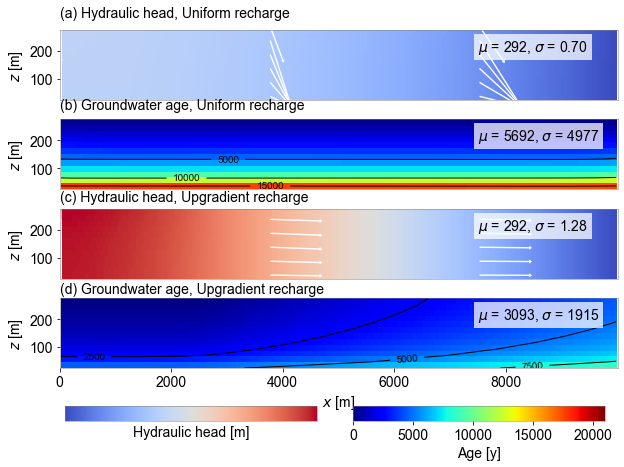

In [42]:
# These values are to display on the plots
mean_a = (statsDict[rechargeScenarioNames[0]].loc["CS_0", "mean_head"])
mean_b = int(statsDict[rechargeScenarioNames[0]].loc["CS_0", "mean_age"])
mean_c = (statsDict[rechargeScenarioNames[1]].loc["CS_0", "mean_head"])
mean_d = int(statsDict[rechargeScenarioNames[1]].loc["CS_0", "mean_age"])
std_a = (statsDict[rechargeScenarioNames[0]].loc["CS_0", "std_head"])
std_b = int(statsDict[rechargeScenarioNames[0]].loc["CS_0", "std_age"])
std_c = (statsDict[rechargeScenarioNames[1]].loc["CS_0", "std_head"])
std_d = int(statsDict[rechargeScenarioNames[1]].loc["CS_0", "std_age"])

#==================================
fig = plt.figure(figsize = (10, 7))
#===================================

# # # Recharge Scenario 1: Head
caseStudy = 0
rechargeScenario = 0
ax1 = fig.add_subplot(4, 1, 1)

qx_avg = np.empty(frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].shape, 
                  dtype=frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].dtype)
qx_avg[:, :, 1:] = 0.5 * (frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 0:ncol-1] + 
                            frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 1:ncol])
qx_avg[:, :, 0] = 0.5 * frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 0]


qz_avg = np.empty(flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].shape, 
                  dtype=flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].dtype)
qz_avg[1:, :, :] = 0.5 * (flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][0:nlay-1, :, :] + 
                    flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][1:nlay, :, :])
qz_avg[0, :, :] = 0.5 * flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][0, :, :]


ml = modelObjectDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
mm = flopy.plot.crosssection.ModelCrossSection(model=ml, line={'row':row_cross_section})                
extent = (delr/2., Lx - delr/2., ztop - delc/2., delc/2.)  # values from model
raster = headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, row_cross_section, :]
img1 = ax1.imshow(np.flipud(raster), cmap=head_cmap, extent=extent, aspect=5, vmin = head_min, vmax = head_max) # 
axes1 = plt.gca()
axes1.set_ylim([25, 275])
plt.ylabel('$z$ [m]')
axes1.get_xaxis().set_visible(False)

y, x, z = nodeCoordsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
X, Z = np.meshgrid(x, z[:, 0, 0])

plt.quiver(X[::iskipLayers, ::iskipCols], Z[::iskipLayers, ::iskipCols],
           colDisMultiplyer*qx_avg[::iskipLayers, row_cross_section, ::iskipCols], 
            layerDisMultiplyer*(-qz_avg[::iskipLayers, row_cross_section, ::iskipCols]),
           color='w', scale=5, headwidth=3, headlength=2,
           headaxislength=2, width=0.0025)


# # # Recharge Scenario 1: Age

ax2 = fig.add_subplot(4, 1, 2)
ml = modelObjectDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
mm = flopy.plot.crosssection.ModelCrossSection(model=ml, line={'row':row_cross_section})                
extent = (delr/2., Lx - delr/2., ztop - delc/2., delc/2.)  # values from model
raster = ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, row_cross_section, :]
img2 = ax2.imshow(np.flipud(raster), cmap=age_cmap, extent=extent, aspect=5, vmin = age_min, vmax = age_max) # 

cs = plt.contour(raster, levels=levels, extent=extent, colors=contour_colors) 
plt.clabel(cs, inline=1, fontsize=10, fmt='%1i', colors=contour_colors)

axes2 = plt.gca()
axes2.set_ylim([25, 275])
plt.ylabel('$z$ [m]')
axes2.get_xaxis().set_visible(False)

# # # Recharge Scenario 2: Head

caseStudy = 0
rechargeScenario = 1
ax3 = fig.add_subplot(4, 1, 3)

qx_avg = np.empty(frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].shape, 
                  dtype=frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].dtype)
qx_avg[:, :, 1:] = 0.5 * (frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 0:ncol-1] + 
                            frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 1:ncol])
qx_avg[:, :, 0] = 0.5 * frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 0]

qz_avg = np.empty(flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].shape, 
                  dtype=flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].dtype)
qz_avg[1:, :, :] = 0.5 * (flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][0:nlay-1, :, :] + 
                    flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][1:nlay, :, :])
qz_avg[0, :, :] = 0.5 * flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][0, :, :]

ml = modelObjectDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
mm = flopy.plot.crosssection.ModelCrossSection(model=ml, line={'row':row_cross_section})                
extent = (delr/2., Lx - delr/2., ztop - delc/2., delc/2.)  # values from model
raster = headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, row_cross_section, :]
img3 = ax3.imshow(np.flipud(raster), cmap=head_cmap, extent=extent, aspect=5) # , vmin = head_min, vmax = head_max
axes3 = plt.gca()
axes3.set_ylim([25, 275])
plt.ylabel('$z$ [m]')
axes3.get_xaxis().set_visible(False)

y, x, z = nodeCoordsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
X, Z = np.meshgrid(x, z[:, 0, 0])

plt.quiver(X[::iskipLayers, ::iskipCols], Z[::iskipLayers, ::iskipCols],
           colDisMultiplyer*qx_avg[::iskipLayers, row_cross_section, ::iskipCols], 
            layerDisMultiplyer*(-qz_avg[::iskipLayers, row_cross_section, ::iskipCols]),
           color='w', scale=5, headwidth=3, headlength=2,
           headaxislength=2, width=0.0025)


# # # Recharge Scenario 2: Age

ax4 = fig.add_subplot(4, 1, 4)
ml = modelObjectDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
mm = flopy.plot.crosssection.ModelCrossSection(model=ml, line={'row':row_cross_section})                
extent = (delr/2., Lx - delr/2., ztop - delc/2., delc/2.)  # values from model
raster = ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, row_cross_section, :]
img4 = ax4.imshow(np.flipud(raster), cmap=age_cmap, extent=extent, aspect=5, vmin = age_min, vmax = age_max)# 


#print(get ready for manual contour labels)
cs = plt.contour(raster, levels=levels_2, extent=extent, colors=contour_colors) 
plt.clabel(cs, inline=1, manual = manual_plot, fontsize=10, fmt='%1i', colors=contour_colors)

axes4 = plt.gca()
axes4.set_ylim([25, 275])
plt.ylabel('$z$ [m]')
plt.xlabel('$x$ [m]')

# Adding colour-bars

plt.subplots_adjust(bottom=0.2)

cbaxes1 = fig.add_axes([0.133, 0.1, 0.35, 0.03]) 
cb1 = plt.colorbar(img1, cax = cbaxes1, orientation="horizontal")  
cb1.set_label('Hydraulic head [m]')
tick_locator = ticker.MaxNLocator(nbins = 5)
cb1.locator = tick_locator
cb1.update_ticks()

cbaxes2 = fig.add_axes([0.533, 0.1, 0.35, 0.03]) 
cb2 = plt.colorbar(img2, cax = cbaxes2, orientation="horizontal")  
cb2.set_label('Age [y]')
cb2.locator = tick_locator
cb2.update_ticks()

# Adding text to indicate which recharge scenario
bbox_props = {'facecolor':'white', 'alpha':0.75, 'lw':0}
axes1.text(7500, 200, (r"$\mu$ = %.0f, $\sigma$ = %.2f" % (mean_a, std_a)),
           bbox=bbox_props)
axes2.text(7500, 200, (r"$\mu$ = " + str(mean_b) + r", $\sigma$ = " +str(std_b)),
           bbox=bbox_props)
axes3.text(7500, 200, (r"$\mu$ = %.0f, $\sigma$ = %.2f" % (mean_c, std_c)),
           bbox=bbox_props)
axes4.text(7500, 200, (r"$\mu$ = " + str(mean_d) + r", $\sigma$ = " +str(std_d)),
           bbox=bbox_props)

gap_amount = .146

# Use position values for the text, i.e. (x, (y + height), ...
plt.gcf().text(0.125, (0.7544685976449275+gap_amount), "(a) Hydraulic head, Uniform recharge")
plt.gcf().text(0.125, (0.5718599019927537+gap_amount), "(b) Groundwater age, Uniform recharge")
plt.gcf().text(0.125, (0.3892512063405797+gap_amount), "(c) Hydraulic head, Upgradient recharge")
plt.gcf().text(0.125, (0.20664251068840572+gap_amount), "(d) Groundwater age, Upgradient recharge")

# Saving the plot
name = "fig_3"
plt.savefig(os.path.join(figureDirectory, name), dpi = dpi_value)

## Figure 4 (CASE STUDY 1)

Fig. 4 Fully-penetrating barrier results with uniform recharge (a–c) and upgradient recharge (d–f),
shown as a cross-section taken through the centre of the y axis of the model. Results show hydraulic
head distributions (a, d); groundwater age distributions (b, e); and normalised differences in
groundwater age (c, f). The arrows on (a) and (d) indicate groundwater flow direction with their length scaled arithmetically by the groundwater velocity.

C:\Program Files\Anaconda3\lib\site-packages\flopy\plot\crosssection.py:859: PendingDeprecationWarning: ModelCrossSection will be replaced by PlotCrossSection(), Calling PlotCrossSection()
  warnings.warn(err_msg, PendingDeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\flopy\plot\crosssection.py:859: PendingDeprecationWarning: ModelCrossSection will be replaced by PlotCrossSection(), Calling PlotCrossSection()
  warnings.warn(err_msg, PendingDeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\flopy\plot\crosssection.py:859: PendingDeprecationWarning: ModelCrossSection will be replaced by PlotCrossSection(), Calling PlotCrossSection()
  warnings.warn(err_msg, PendingDeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\flopy\plot\crosssection.py:859: PendingDeprecationWarning: ModelCrossSection will be replaced by PlotCrossSection(), Calling PlotCrossSection()
  warnings.warn(err_msg, PendingDeprecationWarning)
C:\Program Files\Anaconda3\lib\site-

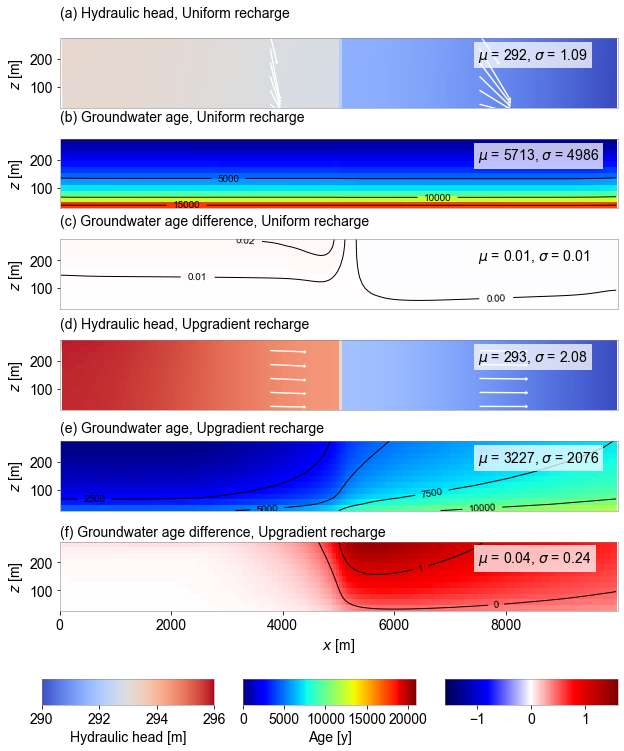

In [43]:
mean_a = (statsDict[rechargeScenarioNames[0]].loc["CS_1", "mean_head"])
mean_b = int(statsDict[rechargeScenarioNames[0]].loc["CS_1", "mean_age"])
mean_c = statsDict[rechargeScenarioNames[0]].loc["CS_1", "mean_diff_age_gamma"]
mean_d = (statsDict[rechargeScenarioNames[1]].loc["CS_1", "mean_head"])
mean_e = int(statsDict[rechargeScenarioNames[1]].loc["CS_1", "mean_age"])
mean_f = statsDict[rechargeScenarioNames[1]].loc["CS_1", "mean_diff_age_gamma"]

std_a = (statsDict[rechargeScenarioNames[0]].loc["CS_1", "std_head"])
std_b = int(statsDict[rechargeScenarioNames[0]].loc["CS_1", "std_age"])
std_c = statsDict[rechargeScenarioNames[0]].loc["CS_1", "std_diff_age_gamma"]
std_d = (statsDict[rechargeScenarioNames[1]].loc["CS_1", "std_head"])
std_e = int(statsDict[rechargeScenarioNames[1]].loc["CS_1", "std_age"])
std_f = statsDict[rechargeScenarioNames[1]].loc["CS_1", "std_diff_age_gamma"]

                    
#==================================
fig = plt.figure(figsize = (10, 12))
#===================================

# # # Recharge Scenario 1: Head
caseStudy = 1
rechargeScenario = 0
ax1 = fig.add_subplot(6, 1, 1)

qx_avg = np.empty(frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].shape, 
                  dtype=frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].dtype)
qx_avg[:, :, 1:] = 0.5 * (frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 0:ncol-1] + 
                            frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 1:ncol])
qx_avg[:, :, 0] = 0.5 * frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 0]

qz_avg = np.empty(flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].shape, 
                  dtype=flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].dtype)
qz_avg[1:, :, :] = 0.5 * (flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][0:nlay-1, :, :] + 
                    flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][1:nlay, :, :])
qz_avg[0, :, :] = 0.5 * flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][0, :, :]

ml = modelObjectDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
mm = flopy.plot.crosssection.ModelCrossSection(model=ml, line={'row':row_cross_section})                
extent = (delr/2., Lx - delr/2., ztop - delc/2., delc/2.)  # values from model
raster = headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, row_cross_section, :]
img1 = ax1.imshow(np.flipud(raster), cmap=head_cmap, extent=extent, aspect=5, vmin = head_min, vmax = head_max) # 
axes1 = plt.gca()
axes1.set_ylim([25, 275])
plt.ylabel('$z$ [m]')
axes1.get_xaxis().set_visible(False)


y, x, z = nodeCoordsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
X, Z = np.meshgrid(x, z[:, 0, 0])

plt.quiver(X[::iskipLayers, ::iskipCols], Z[::iskipLayers, ::iskipCols],
           colDisMultiplyer*qx_avg[::iskipLayers, row_cross_section, ::iskipCols], 
            layerDisMultiplyer*(-qz_avg[::iskipLayers, row_cross_section, ::iskipCols]),
           color='w', scale=6, headwidth=3, headlength=2,
           headaxislength=2, width=0.0025)

# # # Recharge Scenario 1: Age

ax2 = fig.add_subplot(6, 1, 2)
ml = modelObjectDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
mm = flopy.plot.crosssection.ModelCrossSection(model=ml, line={'row':row_cross_section})                
extent = (delr/2., Lx - delr/2., ztop - delc/2., delc/2.)  # values from model
raster = ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, row_cross_section, :]
img2 = ax2.imshow(np.flipud(raster), cmap=age_cmap, extent=extent, aspect=5, vmin = age_min, vmax = age_max) # 

cs = plt.contour(raster, levels=levels, extent=extent, colors=contour_colors) 
plt.clabel(cs, inline=1, fontsize=10, fmt='%1i', colors=contour_colors)

axes2 = plt.gca()
axes2.set_ylim([25, 275])
plt.ylabel('$z$ [m]')
axes2.get_xaxis().set_visible(False)

# # # Recharge Scenario 1: Difference in Age (gamma)

# ---
data_3 = gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, row_cross_section, :]
sigma = 4.0 # this depends on how noisy your data is, play with it!
filter_3 = gaussian_filter(data_3, sigma)
# ---

gamma_cs_labels_2 = np.linspace(-0.1, 0.1, 21)

ax3 = fig.add_subplot(6, 1, 3)
ml = modelObjectDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
mm = flopy.plot.crosssection.ModelCrossSection(model=ml, line={'row':row_cross_section})                
extent = (delr/2., Lx - delr/2., ztop - delc/2., delc/2.)  # values from model
raster = filter_3
img3 = ax3.imshow(np.flipud(raster), cmap=diff_age_cmap, extent=extent, aspect=5, vmin = gamma_age_min, vmax = gamma_age_max) # 

cs = plt.contour(raster, levels=gamma_cs_labels_2, extent=extent, colors=contour_colors) 
plt.clabel(cs, gamma_cs_labels_2, inline=1, fontsize=10, fmt='%1.2f', colors=contour_colors)

axes3 = plt.gca()
axes3.set_ylim([25, 275])
plt.ylabel('$z$ [m]')
axes3.get_xaxis().set_visible(False)

# # # Recharge Scenario 2: Head

rechargeScenario = 1
ax4 = fig.add_subplot(6, 1, 4)

qx_avg = np.empty(frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].shape, 
                  dtype=frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].dtype)
qx_avg[:, :, 1:] = 0.5 * (frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 0:ncol-1] + 
                            frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 1:ncol])
qx_avg[:, :, 0] = 0.5 * frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 0]

qz_avg = np.empty(flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].shape, 
                  dtype=flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].dtype)
qz_avg[1:, :, :] = 0.5 * (flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][0:nlay-1, :, :] + 
                    flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][1:nlay, :, :])
qz_avg[0, :, :] = 0.5 * flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][0, :, :]

ml = modelObjectDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
mm = flopy.plot.crosssection.ModelCrossSection(model=ml, line={'row':row_cross_section})                
extent = (delr/2., Lx - delr/2., ztop - delc/2., delc/2.)  # values from model
raster = headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, row_cross_section, :]
img4 = ax4.imshow(np.flipud(raster), cmap=head_cmap, extent=extent, aspect=5, vmin = head_min, vmax = head_max) # 
axes4 = plt.gca()
axes4.set_ylim([25, 275])
plt.ylabel('$z$ [m]')
axes4.get_xaxis().set_visible(False)

y, x, z = nodeCoordsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
X, Z = np.meshgrid(x, z[:, 0, 0])

plt.quiver(X[::iskipLayers, ::iskipCols], Z[::iskipLayers, ::iskipCols],
           colDisMultiplyer*qx_avg[::iskipLayers, row_cross_section, ::iskipCols], 
            layerDisMultiplyer*(-qz_avg[::iskipLayers, row_cross_section, ::iskipCols]),
           color='w', scale=5, headwidth=3, headlength=2,
           headaxislength=2, width=0.0025)

# # # Recharge Scenario 2: Age

ax5 = fig.add_subplot(6, 1, 5)
ml = modelObjectDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
mm = flopy.plot.crosssection.ModelCrossSection(model=ml, line={'row':row_cross_section})                
extent = (delr/2., Lx - delr/2., ztop - delc/2., delc/2.)  # values from model
raster = ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, row_cross_section, :]
img5 = ax5.imshow(np.flipud(raster), cmap=age_cmap, extent=extent, aspect=5, vmin = age_min, vmax = age_max) 

#print(get ready for manual contour labels)
cs = plt.contour(raster, levels=levels_2, extent=extent, colors=contour_colors) 
plt.clabel(cs, inline=1, manual=manual_plot, fontsize=10, fmt='%1i', colors=contour_colors)

axes5 = plt.gca()
axes5.set_ylim([25, 275])
plt.ylabel('$z$ [m]')
axes5.get_xaxis().set_visible(False)

# # # Recharge Scenario 2: Gamma difference in age

ax6 = fig.add_subplot(6, 1, 6)
ml = modelObjectDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
mm = flopy.plot.crosssection.ModelCrossSection(model=ml, line={'row':row_cross_section})                
extent = (delr/2., Lx - delr/2., ztop - delc/2., delc/2.)  # values from model
raster = gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, row_cross_section, :]
img6 = ax6.imshow(np.flipud(raster), cmap=diff_age_cmap, extent=extent, aspect=5, vmin = gamma_age_min, vmax = gamma_age_max) 

#print(get ready for manual contour labels)
cs = plt.contour(raster, levels=gamma_cs_labels, extent=extent, colors=contour_colors) 
plt.clabel(cs, gamma_cs_labels, inline=1, manual=manual_plot, fontsize=10, fmt='%1i', colors=contour_colors)

axes6 = plt.gca()
axes6.set_ylim([25, 275])
plt.ylabel('$z$ [m]')
plt.xlabel('$x$ [m]')

# Adding colour-bars

plt.subplots_adjust(bottom=0.2)

cbaxes1 = fig.add_axes([.1, 0.1, 0.24, 0.03]) 
cb1 = plt.colorbar(img1, cax = cbaxes1, orientation="horizontal")  
cb1.set_label('Hydraulic head [m]')
#tick_locator = ticker.MaxNLocator(nbins = 5)
#cb1.locator = tick_locator
#cb1.update_ticks()

cbaxes2 = fig.add_axes([.38, 0.1, 0.24, 0.03]) 
cb2 = plt.colorbar(img2, cax = cbaxes2, orientation="horizontal")  
cb2.set_label('Age [y]')
cb2.locator = tick_locator
cb2.update_ticks()

cbaxes3 = fig.add_axes([0.66, 0.1, 0.24, 0.03]) 
cb3 = plt.colorbar(img3, cax = cbaxes3, orientation="horizontal")  
#cb3.set_label(r'$\Gamma\rm{^a}$ [-]') #r'$\Gamma^a$ [-]')  u'${\u0413}\\rm{^a}$ [-]'
#cb3.locator = tick_locator
#cb3.update_ticks()

# Adding text to indicate which recharge scenario

bbox_props = {'facecolor':'white', 'alpha':0.75, 'lw':0}
axes1.text(7500, 200, (r"$\mu$ = %.0f, $\sigma$ = %.2f" % (mean_a, std_a)),
           bbox=bbox_props)
axes2.text(7500, 200, (r"$\mu$ = " + str(mean_b) + r", $\sigma$ = " +str(std_b)),
           bbox=bbox_props)
axes3.text(7500, 200, (r"$\mu$ = %.2f, $\sigma$ = %.2f" % (mean_c, std_c)),
           bbox=bbox_props)
axes4.text(7500, 200, (r"$\mu$ = %.0f, $\sigma$ = %.2f" % (mean_d, std_d)),
           bbox=bbox_props)
axes5.text(7500, 200, (r"$\mu$ = " + str(mean_e) + r", $\sigma$ = " +str(std_e)),
           bbox=bbox_props)
axes6.text(7500, 200, (r"$\mu$ = %.2f, $\sigma$ = %.2f" % (mean_f, std_f)),
           bbox=bbox_props)

# Use position values for the text, i.e. (x, (y + height), ...
gap_amount = .086
plt.gcf().text(0.125, (0.8095511474164927+gap_amount), "(a) Hydraulic head, Uniform recharge")
plt.gcf().text(0.125, (0.6895511474164927+gap_amount), "(b) Groundwater age, Uniform recharge")
plt.gcf().text(0.125, (0.5695511474164927+gap_amount), "(c) Groundwater age difference, Uniform recharge")
plt.gcf().text(0.125, (0.4495511474164927+gap_amount), "(d) Hydraulic head, Upgradient recharge")
plt.gcf().text(0.125, (0.3295511474164927+gap_amount), "(e) Groundwater age, Upgradient recharge")
plt.gcf().text(0.125, (0.20955114741649272+gap_amount), "(f) Groundwater age difference, Upgradient recharge")

# Saving the plot
name = "fig_4"
plt.savefig(os.path.join(figureDirectory, name), dpi = dpi_value)

## Figure 5 (CASE STUDY 1)

Fig. 5 a Hydraulic head difference and b normalised groundwater age difference for the fully-penetrating barrier with uniform recharge, in a plan-view slice through the upper half of the
z axis (z = 237.5 m). Positive values for both hydraulic head difference and normalised
groundwater age difference indicate that the value for the barrier scenario is higher than that for the non-barrier scenario. The arrows (b) indicate the groundwater flow direction, with their length scaled arithmetically by groundwater velocity. Contours are shown as solid or dashed black lines where the contour represents a positive or negative value, respectively.

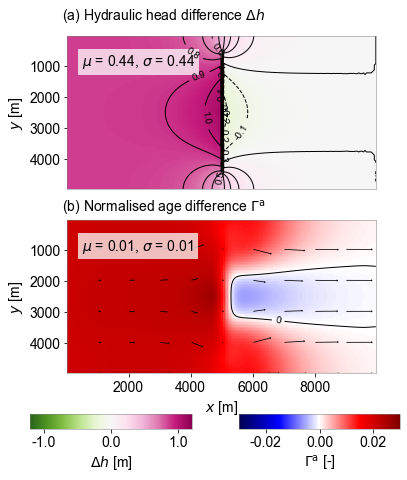

In [44]:
## ABSOLUTE DIFFERENCE IN HEAD/AGE - Case Study 1
# Uniform recharge 
min_abs_head_diff = -1.2
max_abs_head_diff = 1.2
min_abs_age_diff = -100
max_abs_age_diff = 100

caseStudy = 1
rechargeScenario = 0
nLayer = 1 

mean_a = (statsDict[rechargeScenarioNames[0]].loc["CS_1", "mean_diff_head_abs"])
mean_b = (statsDict[rechargeScenarioNames[0]].loc["CS_1", "mean_diff_age_gamma"])
std_a = (statsDict[rechargeScenarioNames[0]].loc["CS_1", "std_diff_head_abs"])
std_b = (statsDict[rechargeScenarioNames[0]].loc["CS_1", "std_diff_age_gamma"])

# These values are for colour-bar evaluation purposes only

max_head_plot = [np.amax(diffHeadAbsDict[rechargeScenarioNames[0]][caseStudyNames[caseStudy]][nLayer, :, :]),
       np.amax(diffHeadAbsDict[rechargeScenarioNames[1]][caseStudyNames[caseStudy]][nLayer, :, :])]

max_age_plot = [np.amax(gammaAgeDict[rechargeScenarioNames[0]][caseStudyNames[caseStudy]][nLayer, :, :]),
       np.amax(gammaAgeDict[rechargeScenarioNames[1]][caseStudyNames[caseStudy]][nLayer, :, :])]

min_head_plot = [np.amin(diffHeadAbsDict[rechargeScenarioNames[0]][caseStudyNames[caseStudy]][nLayer, :, :]),
       np.amin(diffHeadAbsDict[rechargeScenarioNames[1]][caseStudyNames[caseStudy]][nLayer, :, :])]

min_age_plot = [np.amin(gammaAgeDict[rechargeScenarioNames[0]][caseStudyNames[caseStudy]][nLayer, :, :]),
       np.amin(gammaAgeDict[rechargeScenarioNames[1]][caseStudyNames[caseStudy]][nLayer, :, :])]


qx_avg = np.empty(frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].shape, 
                  dtype=frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].dtype)
qx_avg[:, :, 1:] = 0.5 * (frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 0:ncol-1] + 
                            frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 1:ncol])
qx_avg[:, :, 0] = 0.5 * frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 0]

qy_avg = np.empty(fffDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].shape, 
                  dtype=fffDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].dtype)

qy_avg[:, 1:, :] = 0.5 * (fffDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, 0:nrow-1, :] + 
                    fffDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, 1:nrow, :])

qy_avg[:, 0, :] = 0.5 * fffDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, 0, :]               
                          
levels_1 = np.arange(-1.2, 1.2, 0.2)
diff_head_contours = np.linspace(-2, 2, 41)

#==================================
fig = plt.figure(figsize = (7, 7))
#==================================

ax1 = fig.add_subplot(2, 1, 1)
extent = (delr/2., Lx - delr/2., Ly - delc/2., delc/2.)
raster1 = diffHeadAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][nLayer, :, :]
img1 = ax1.imshow(np.flipud(raster1), cmap=diff_head_cmap, extent=extent, vmin = min_abs_head_diff, vmax = max_abs_head_diff) # 
axes1 = plt.gca()
plt.ylabel("$y$ [m]")
axes1.axes.get_xaxis().set_visible(False)

cs = plt.contour(raster1, levels=diff_head_contours, extent=extent, colors=contour_colors) 
plt.clabel(cs, diff_head_contours, inline=1, manual=manual_plot, fontsize=10, fmt='%1.1f', colors=contour_colors) #   manual = True, 

# -------- AGE PLOT --------- # 
data_2 = gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][nLayer, :, :]
sigma = 4.0 # this depends on how noisy your data is, play with it!
filter_2 = gaussian_filter(data_2, sigma)
# ---

ax2 = fig.add_subplot(2, 1, 2)
extent = (delr/2., Lx - delr/2., Ly - delc/2., delc/2.)
raster2 = filter_2
img2 = ax2.imshow(np.flipud(raster2), cmap=diff_age_cmap, extent=extent, vmin = -0.03, vmax =0.03) # , vmin = gamma_age_min, vmax = gamma_age_max
axes2 = plt.gca()
plt.xlabel("$x$ [m]")
plt.ylabel("$y$ [m]")

cs = plt.contour(raster2, levels=gamma_cs_labels, extent=extent, colors=contour_colors) 
plt.clabel(cs, gamma_cs_labels, manual=manual_plot, inline=1, fontsize=10, fmt='%1i', colors=contour_colors) #  manual=True, 

y, x, z = nodeCoordsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
X, Y = np.meshgrid(x, y)

iskipRows = 20
iskipCols = 20

plt.quiver(X[::iskipRows, ::iskipCols], Y[::iskipRows, ::iskipCols],
           colDisMultiplyer*qx_avg[nLayer, ::iskipRows, ::iskipCols], 
            rowDisMultiplyer*(qy_avg[nLayer, ::iskipRows, ::iskipCols]),
           color='k', scale=5, headwidth=3, headlength=2,
           headaxislength=2, width=0.0025)

# ---------------------------- #
plt.subplots_adjust(bottom=0.21)

cbaxes1 = fig.add_axes([0.133, 0.1, 0.32, 0.03]) 
cb1 = plt.colorbar(img1, cax = cbaxes1, orientation="horizontal", format='%1.1f')  
cb1.set_label(r'$\Delta h$ [m]')
#tick_locator = ticker.MaxNLocator(nbins = 5)
#cb1.locator = tick_locator
#cb1.update_ticks()

cbaxes2 = fig.add_axes([0.547, 0.1, 0.32, 0.03]) 
cb2 = plt.colorbar(img2, cax = cbaxes2, orientation="horizontal", format='%1.2f')  
cb2.set_label(r'$\Gamma\mathrm{^a}$ [-]')
#cb2.locator = tick_locator
#cb2.update_ticks()

axes1.text(500, 1000, (r"$\mu$ = %.2f, $\sigma$ = %.2f" % (mean_a, std_a)),
           bbox=bbox_props)
axes2.text(500, 1000, (r"$\mu$ = %.2f, $\sigma$ = %.2f" % (mean_b, std_b)),
           bbox=bbox_props)

# Add text to the plot to label the plots
pos1 = axes1.get_position() # shows x, y, width, height
pos2 = axes2.get_position()

# Use position values for the text, i.e. (x, (y + height), ...
gap_amount = 0.33
plt.gcf().text(0.19513686463836777, (0.5818181818181819+gap_amount), r"(a) Hydraulic head difference $\Delta h$")
plt.gcf().text(0.19513686463836777, (0.20000000000000018+gap_amount), r"(b) Normalised age difference $\Gamma\mathrm{^a}$")

# Saving the plot
name = "fig_5"
plt.savefig(os.path.join(figureDirectory, name), dpi = dpi_value)

## Figure 6  (CASE STUDY 1)

Fig. 6 a Hydraulic head difference and b normalised groundwater age difference for the fully-penetrating barrier with upgradient recharge, in a planview slice through the upper half
of the z axis (z = 237.5 m). Positive values for both hydraulic head difference and normalised
groundwater age difference indicate that the value for the barrier scenario is higher than that for the nonbarrier scenario. The arrows (b) indicate the groundwater flow direction, with their length scaled arithmetically by groundwater velocity. Contours are shown as solid or dashed black lines where the contour represents a positive or negative value, respectively.

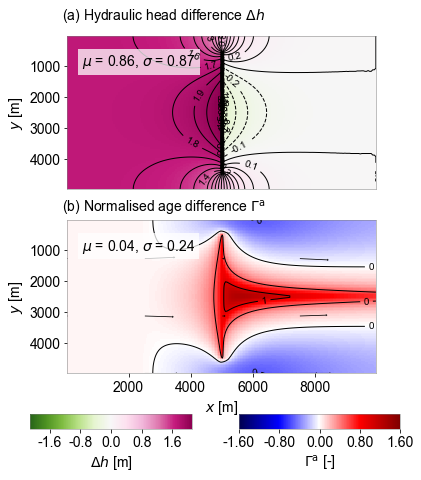

In [45]:
# Uniform recharge 
min_abs_head_diff = -2.1
max_abs_head_diff = 2.1

caseStudy = 1
rechargeScenario = 1
nLayer = 2 

mean_a = (statsDict[rechargeScenarioNames[1]].loc["CS_1", "mean_diff_head_abs"])
mean_b = (statsDict[rechargeScenarioNames[1]].loc["CS_1", "mean_diff_age_gamma"])
std_a = (statsDict[rechargeScenarioNames[1]].loc["CS_1", "std_diff_head_abs"])
std_b = (statsDict[rechargeScenarioNames[1]].loc["CS_1", "std_diff_age_gamma"])

levels_1 = np.arange(-1.2, 1.2, 0.2)

#==================================
fig = plt.figure(figsize = (7, 7))
#==================================

diff_head_contours = np.linspace(-2, 2, 41)


qx_avg = np.empty(frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].shape, 
                  dtype=frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].dtype)
qx_avg[:, :, 1:] = 0.5 * (frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 0:ncol-1] + 
                            frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 1:ncol])
qx_avg[:, :, 0] = 0.5 * frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 0]

qy_avg = np.empty(fffDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].shape, 
                  dtype=fffDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].dtype)

qy_avg[:, 1:, :] = 0.5 * (fffDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, 0:nrow-1, :] + 
                    fffDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, 1:nrow, :])

qy_avg[:, 0, :] = 0.5 * fffDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, 0, :]


ax1 = fig.add_subplot(2, 1, 1)
extent = (delr/2., Lx - delr/2., Ly - delc/2., delc/2.)
raster1 = diffHeadAbsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][nLayer, :, :]
img1 = ax1.imshow(np.flipud(raster1), cmap=diff_head_cmap, extent=extent, vmin = min_abs_head_diff, vmax = max_abs_head_diff) # 
axes1 = plt.gca()
plt.ylabel("$y$ [m]")
axes1.axes.get_xaxis().set_visible(False)

cs = plt.contour(raster1, levels=diff_head_contours, extent=extent, colors=contour_colors) 
plt.clabel(cs, diff_head_contours, inline=1, manual=manual_plot, fontsize=10, fmt='%1.1f', colors=contour_colors) #   manual = True, 

# -------- AGE PLOT --------- # 

ax2 = fig.add_subplot(2, 1, 2)
extent = (delr/2., Lx - delr/2., Ly - delc/2., delc/2.)
raster2 = gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][nLayer, :, :]
img2 = ax2.imshow(np.flipud(raster2), cmap=diff_age_cmap, extent=extent, vmin = gamma_age_min, vmax = gamma_age_max) # 
axes2 = plt.gca()
plt.xlabel("$x$ [m]")
plt.ylabel("$y$ [m]")

cs = plt.contour(raster2, levels=gamma_cs_labels, extent=extent, colors=contour_colors) 
plt.clabel(cs, gamma_cs_labels, inline=1, fontsize=10, fmt='%1i', colors=contour_colors) #  manual=True, 

y, x, z = nodeCoordsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
X, Y = np.meshgrid(x, y)

iskipRows = 37
iskipCols = 50

plt.quiver(X[::iskipRows, ::iskipCols], Y[::iskipRows, ::iskipCols],
           colDisMultiplyer*qx_avg[nLayer, ::iskipRows, ::iskipCols], 
            rowDisMultiplyer*(qy_avg[nLayer, ::iskipRows, ::iskipCols]),
           color='k', scale=5, headwidth=3, headlength=2,
           headaxislength=2, width=0.0025)

# ------------------------------ #
plt.subplots_adjust(bottom=0.21)

cbaxes1 = fig.add_axes([0.133, 0.1, 0.32, 0.03]) 
cb1 = plt.colorbar(img1, cax = cbaxes1, orientation="horizontal", format='%1.1f')  
cb1.set_label(r'$\Delta h$ [m]')
tick_locator = ticker.MaxNLocator(nbins = 5)
cb1.locator = tick_locator
cb1.update_ticks()

cbaxes2 = fig.add_axes([0.547, 0.1, 0.32, 0.03]) 
cb2 = plt.colorbar(img2, cax = cbaxes2, orientation="horizontal", format='%1.2f')  
cb2.set_label(r'$\Gamma\mathrm{^a}$ [-]')
cb2.locator = tick_locator
cb2.update_ticks()


axes1.text(500, 1000, (r"$\mu$ = %.2f, $\sigma$ = %.2f" % (mean_a, std_a)),
           bbox=bbox_props)
axes2.text(500, 1000, (r"$\mu$ = %.2f, $\sigma$ = %.2f" % (mean_b, std_b)),
           bbox=bbox_props)


# Add text to the plot to label the plots
pos1 = axes1.get_position() # shows x, y, width, height
pos2 = axes2.get_position()

# Use position values for the text, i.e. (x, (y + height), ...
gap_amount = 0.33
plt.gcf().text(0.19513686463836777, (0.5818181818181819+gap_amount), r"(a) Hydraulic head difference $\Delta h$")
plt.gcf().text(0.19513686463836777, (0.20000000000000018+gap_amount), r"(b) Normalised age difference $\Gamma\mathrm{^a}$")

# Saving the plot
name = "fig_6"
plt.savefig(os.path.join(figureDirectory, name), dpi = dpi_value)


## Figure 7 (CASE STUDY 2)

Fig. 7 Buried barrier results with uniform recharge (a–c) and upgradient recharge (d–f), shown
as a cross-section taken through the centre of the y axis of the model. Results show hydraulic
head distributions (a, d); groundwater age distributions (b, e); and normalised differences in
groundwater age (c, f). The arrows (a, d) indicate groundwater flow direction with their length
scaled arithmetically by the groundwater velocity.

C:\Program Files\Anaconda3\lib\site-packages\flopy\plot\crosssection.py:859: PendingDeprecationWarning: ModelCrossSection will be replaced by PlotCrossSection(), Calling PlotCrossSection()
  warnings.warn(err_msg, PendingDeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\flopy\plot\crosssection.py:859: PendingDeprecationWarning: ModelCrossSection will be replaced by PlotCrossSection(), Calling PlotCrossSection()
  warnings.warn(err_msg, PendingDeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\flopy\plot\crosssection.py:859: PendingDeprecationWarning: ModelCrossSection will be replaced by PlotCrossSection(), Calling PlotCrossSection()
  warnings.warn(err_msg, PendingDeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\flopy\plot\crosssection.py:859: PendingDeprecationWarning: ModelCrossSection will be replaced by PlotCrossSection(), Calling PlotCrossSection()
  warnings.warn(err_msg, PendingDeprecationWarning)
C:\Program Files\Anaconda3\lib\site-

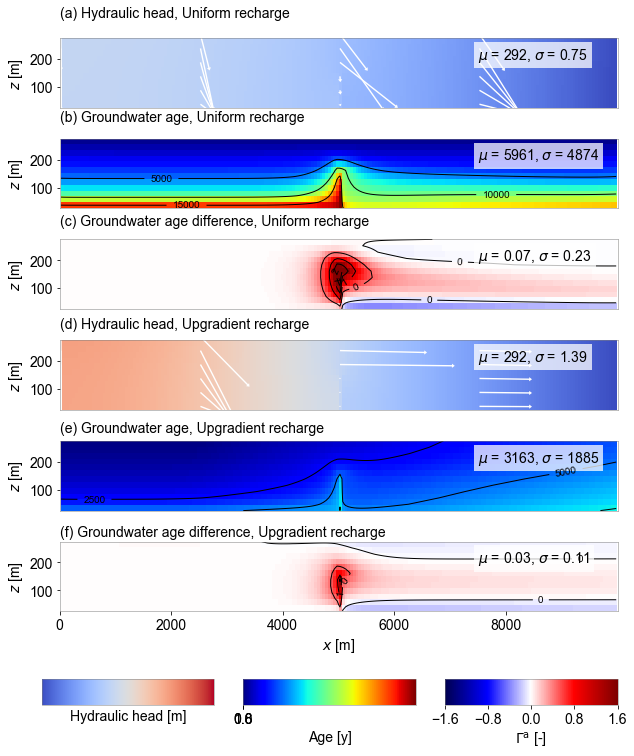

In [46]:
mean_a = (statsDict[rechargeScenarioNames[0]].loc["CS_2", "mean_head"])
mean_b = int(statsDict[rechargeScenarioNames[0]].loc["CS_2", "mean_age"])
mean_c = statsDict[rechargeScenarioNames[0]].loc["CS_2", "mean_diff_age_gamma"]
mean_d = (statsDict[rechargeScenarioNames[1]].loc["CS_2", "mean_head"])
mean_e = int(statsDict[rechargeScenarioNames[1]].loc["CS_2", "mean_age"])
mean_f = statsDict[rechargeScenarioNames[1]].loc["CS_2", "mean_diff_age_gamma"]

std_a = (statsDict[rechargeScenarioNames[0]].loc["CS_2", "std_head"])
std_b = int(statsDict[rechargeScenarioNames[0]].loc["CS_2", "std_age"])
std_c = statsDict[rechargeScenarioNames[0]].loc["CS_2", "std_diff_age_gamma"]
std_d = (statsDict[rechargeScenarioNames[1]].loc["CS_2", "std_head"])
std_e = int(statsDict[rechargeScenarioNames[1]].loc["CS_2", "std_age"])
std_f = statsDict[rechargeScenarioNames[1]].loc["CS_2", "std_diff_age_gamma"]
            
#==================================
fig = plt.figure(figsize = (10, 12))
#===================================

# # # Recharge Scenario 1: Head
caseStudy = 2
rechargeScenario = 0
ax1 = fig.add_subplot(6, 1, 1)

qx_avg = np.empty(frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].shape, 
                  dtype=frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].dtype)
qx_avg[:, :, 1:] = 0.5 * (frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 0:ncol-1] + 
                            frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 1:ncol])
qx_avg[:, :, 0] = 0.5 * frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 0]

qz_avg = np.empty(flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].shape, 
                  dtype=flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].dtype)
qz_avg[1:, :, :] = 0.5 * (flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][0:nlay-1, :, :] + 
                    flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][1:nlay, :, :])
qz_avg[0, :, :] = 0.5 * flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][0, :, :]

ml = modelObjectDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
mm = flopy.plot.crosssection.ModelCrossSection(model=ml, line={'row':row_cross_section})                
extent = (delr/2., Lx - delr/2., ztop - delc/2., delc/2.)  # values from model
raster = headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, row_cross_section, :]
img1 = ax1.imshow(np.flipud(raster), cmap=head_cmap, extent=extent, aspect=5, vmin = head_min, vmax = head_max) # 
axes1 = plt.gca()
axes1.set_ylim([25, 275])
plt.ylabel('$z$ [m]')
axes1.get_xaxis().set_visible(False)

y, x, z = nodeCoordsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
X, Z = np.meshgrid(x, z[:, 0, 0])

plt.quiver(X[::iskipLayers, ::iskipCols], Z[::iskipLayers, ::iskipCols],
           colDisMultiplyer*qx_avg[::iskipLayers, row_cross_section, ::iskipCols], 
            layerDisMultiplyer*(-qz_avg[::iskipLayers, row_cross_section, ::iskipCols]),
           color='w', scale=5, headwidth=3, headlength=2,
           headaxislength=2, width=0.0025)

# # # Recharge Scenario 1: Age

ax2 = fig.add_subplot(6, 1, 2)
ml = modelObjectDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
mm = flopy.plot.crosssection.ModelCrossSection(model=ml, line={'row':row_cross_section})                
extent = (delr/2., Lx - delr/2., ztop - delc/2., delc/2.)  # values from model
raster = ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, row_cross_section, :]
img2 = ax2.imshow(np.flipud(raster), cmap=age_cmap, extent=extent, aspect=5, vmin = age_min, vmax = age_max) # 

cs = plt.contour(raster, levels=levels, extent=extent, colors=contour_colors) 
plt.clabel(cs, inline=1, fontsize=10, fmt='%1i', colors=contour_colors)

axes2 = plt.gca()
axes2.set_ylim([25, 275])
plt.ylabel('$z$ [m]')
axes2.get_xaxis().set_visible(False)

# # # Recharge Scenario 1: Difference in Age (gamma)

ax3 = fig.add_subplot(6, 1, 3)
ml = modelObjectDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
mm = flopy.plot.crosssection.ModelCrossSection(model=ml, line={'row':row_cross_section})                
extent = (delr/2., Lx - delr/2., ztop - delc/2., delc/2.)  # values from model
raster = gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, row_cross_section, :]
img3 = ax3.imshow(np.flipud(raster), cmap=diff_age_cmap, extent=extent, aspect=5, vmin = gamma_age_min, vmax = gamma_age_max) # 

cs = plt.contour(raster, levels=gamma_cs_labels, extent=extent, colors=contour_colors) 
plt.clabel(cs, gamma_cs_labels, inline=1, fontsize=10, fmt='%1i', colors=contour_colors)

axes3 = plt.gca()
axes3.set_ylim([25, 275])
plt.ylabel('$z$ [m]')
axes3.get_xaxis().set_visible(False)

# # # Recharge Scenario 2: Head

rechargeScenario = 1
ax4 = fig.add_subplot(6, 1, 4)

qx_avg = np.empty(frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].shape, 
                  dtype=frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].dtype)
qx_avg[:, :, 1:] = 0.5 * (frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 0:ncol-1] + 
                            frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 1:ncol])
qx_avg[:, :, 0] = 0.5 * frfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, :, 0]

qz_avg = np.empty(flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].shape, 
                  dtype=flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]].dtype)
qz_avg[1:, :, :] = 0.5 * (flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][0:nlay-1, :, :] + 
                    flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][1:nlay, :, :])
qz_avg[0, :, :] = 0.5 * flfDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][0, :, :]

ml = modelObjectDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
mm = flopy.plot.crosssection.ModelCrossSection(model=ml, line={'row':row_cross_section})                
extent = (delr/2., Lx - delr/2., ztop - delc/2., delc/2.)  # values from model
raster = headDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, row_cross_section, :]
img4 = ax4.imshow(np.flipud(raster), cmap=head_cmap, extent=extent, aspect=5, vmin = head_min, vmax = head_max) # 
axes4 = plt.gca()
axes4.set_ylim([25, 275])
plt.ylabel('$z$ [m]')
axes4.get_xaxis().set_visible(False)

y, x, z = nodeCoordsDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
X, Z = np.meshgrid(x, z[:, 0, 0])

plt.quiver(X[::iskipLayers, ::iskipCols], Z[::iskipLayers, ::iskipCols],
           colDisMultiplyer*qx_avg[::iskipLayers, row_cross_section, ::iskipCols], 
            layerDisMultiplyer*(-qz_avg[::iskipLayers, row_cross_section, ::iskipCols]),
           color='w', scale=5, headwidth=3, headlength=2,
           headaxislength=2, width=0.0025)

# # # Recharge Scenario 2: Age

ax5 = fig.add_subplot(6, 1, 5)
ml = modelObjectDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
mm = flopy.plot.crosssection.ModelCrossSection(model=ml, line={'row':row_cross_section})                
extent = (delr/2., Lx - delr/2., ztop - delc/2., delc/2.)  # values from model
raster = ageDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, row_cross_section, :]
img5 = ax5.imshow(np.flipud(raster), cmap=age_cmap, extent=extent, aspect=5, vmin = age_min, vmax = age_max) 

#print(get ready for manual contour labels)
cs = plt.contour(raster, levels=levels_2, extent=extent, colors=contour_colors) 
plt.clabel(cs, inline=1, manual=manual_plot, fontsize=10, fmt='%1i', colors=contour_colors)

axes5 = plt.gca()
axes5.set_ylim([25, 275])
plt.ylabel('$z$ [m]')
axes5.get_xaxis().set_visible(False)

# # # Recharge Scenario 2: Gamma difference in age

ax6 = fig.add_subplot(6, 1, 6)
ml = modelObjectDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]]
mm = flopy.plot.crosssection.ModelCrossSection(model=ml, line={'row':row_cross_section})                
extent = (delr/2., Lx - delr/2., ztop - delc/2., delc/2.)  # values from model
raster = gammaAgeDict[rechargeScenarioNames[rechargeScenario]][caseStudyNames[caseStudy]][:, row_cross_section, :]
img6 = ax6.imshow(np.flipud(raster), cmap=diff_age_cmap, extent=extent, aspect=5, vmin = gamma_age_min, vmax = gamma_age_max) 

cs = plt.contour(raster, levels=gamma_cs_labels, extent=extent, colors=contour_colors) 
plt.clabel(cs, gamma_cs_labels, inline=1, fontsize=10, fmt='%1i', colors=contour_colors)

axes6 = plt.gca()
axes6.set_ylim([25, 275])
plt.ylabel('$z$ [m]')
plt.xlabel('$x$ [m]')

# Adding colour-bars

plt.subplots_adjust(bottom=0.2)

cbaxes1 = fig.add_axes([.1, 0.1, 0.24, 0.03]) 
cb1 = plt.colorbar(img1, cax = cbaxes1, orientation="horizontal")  
cb1.set_label('Hydraulic head [m]')
tick_locator = ticker.MaxNLocator(nbins = 5)
cb1.locator = tick_locator
cb1.update_ticks()

cbaxes2 = fig.add_axes([.38, 0.1, 0.24, 0.03]) 
cb2 = plt.colorbar(img2, cax = cbaxes2, orientation="horizontal")  
cb2.set_label('Age [y]')
cb2.locator = tick_locator
cb2.update_ticks()

cbaxes3 = fig.add_axes([0.66, 0.1, 0.24, 0.03]) 
cb3 = plt.colorbar(img3, cax = cbaxes3, orientation="horizontal")  
cb3.set_label(r'$\Gamma\mathrm{^a}$ [-]')
cb3.locator = tick_locator
cb3.update_ticks()

# Adding text to indicate which recharge scenario
#plt.gcf().text(0.92, (0.8), "Recharge 1", fontsize=14, rotation=90*3)        
#plt.gcf().text(0.92, (0.45), "Recharge 2", fontsize=14, rotation=90*3) 
bbox_props = {'facecolor':'white', 'alpha':0.75, 'lw':0}
axes1.text(7500, 200, (r"$\mu$ = %.0f, $\sigma$ = %.2f" % (mean_a, std_a)),
           bbox=bbox_props)
axes2.text(7500, 200, (r"$\mu$ = " + str(mean_b) + r", $\sigma$ = " +str(std_b)),
           bbox=bbox_props)
axes3.text(7500, 200, (r"$\mu$ = %.2f, $\sigma$ = %.2f" % (mean_c, std_c)),
           bbox=bbox_props)
axes4.text(7500, 200, (r"$\mu$ = %.0f, $\sigma$ = %.2f" % (mean_d, std_d)),
           bbox=bbox_props)
axes5.text(7500, 200, (r"$\mu$ = " + str(mean_e) + r", $\sigma$ = " +str(std_e)),
           bbox=bbox_props)
axes6.text(7500, 200, (r"$\mu$ = %.2f, $\sigma$ = %.2f" % (mean_f, std_f)),
           bbox=bbox_props)

# Add text to the plot to label the plots
pos1 = axes1.get_position() # shows x, y, width, height
pos2 = axes2.get_position()
pos3 = axes3.get_position()
pos4 = axes4.get_position()
pos5 = axes5.get_position()
pos6 = axes6.get_position()

# Use position values for the text, i.e. (x, (y + height), ...
gap_amount = .086
plt.gcf().text(0.125, (0.8095511474164927+gap_amount), "(a) Hydraulic head, Uniform recharge")
plt.gcf().text(0.125, (0.6895511474164927+gap_amount), "(b) Groundwater age, Uniform recharge")
plt.gcf().text(0.125, (0.5695511474164927+gap_amount), "(c) Groundwater age difference, Uniform recharge")
plt.gcf().text(0.125, (0.4495511474164927+gap_amount), "(d) Hydraulic head, Upgradient recharge")
plt.gcf().text(0.125, (0.3295511474164927+gap_amount), "(e) Groundwater age, Upgradient recharge")
plt.gcf().text(0.125, (0.20955114741649272+gap_amount), "(f) Groundwater age difference, Upgradient recharge")

# Saving the plot
name = "fig_7"
plt.savefig(os.path.join(figureDirectory, name), dpi = dpi_value)

# Running angled barrier models

Here, I will just show the head and age plots so won't use the same dictionary-type set up as last time.

In [182]:
angles 
hk_arrays_angled 
ang_head_rstrs = []
ang_age_rstrs = []

t1 = time.time()

for angle_i in range(len(angles)):
    
    print("Starting run for angle: %2.2f" %angles[angle_i])

    hk_array_4 = hk_arrays_angled[angle_i]
    
    modelname, modelname_mt3d, mf = flow_model(1, 3)
    mt = transport_model(modelname, modelname_mt3d, mf)
    
    headobj = bf.HeadFile(modelname + '.hds')
    head_times = headobj.get_times()
    head_raster = headobj.get_data(totim=head_times[0])
    
    ang_head_rstrs.append(head_raster)
    
    directage_file = modelname_mt3d + str('.ucn') 
    ucnobjc_direct_age = flopy.utils.binaryfile.UcnFile(directage_file, precision = model_precision)
    age_times = ucnobjc_direct_age.get_times()
    age_raster = ucnobjc_direct_age.get_data(totim=age_times[0])
    
    ang_age_rstrs.append(age_raster)
    
print("Finished running all scenarios")
t2 = time.time()  
run_time = t2-t1      
print("Total run time: " + str(run_time) + "seconds") 

Starting run for angle: 11.25
Flow model name: TB_01_R1_CS3
Transport model name: TB_01_mt3d_R1_CS3
Discretisation module set up
Setting up hk array for Case Study 3
Upstream weighting package set up
Newton solver set up
Setting up recharge array for Recharge Scenario 2
Recharge package set up
General head boundary package set up
Output control package set up
Basic package set up
Link-Mass Transport package set up
Input written
END: Flow model has been run
FloPy is using the following  executable to run the model: C:\Program Files\mt3d-usgs_Distribution\bin\MT3D-USGS_64.exe

 MT3D-USGS - Modular 3D Multi-Species Transport Model [Ver 1.00.00] 
 and based on MT3DMS. MT3D-USGS developed in cooperation by 
 S.S. Papadopulos & Associates and the U.S. Geological Survey

 Using NAME File: TB_01_mt3d_R1_CS3.mtnam

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    1.0000    

 Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1.0000    
 Outer Iter. 

 Outer Iter.  3  Inner Iter. 16:  Max. DC =  0.1192E-05  [K,I,J]   12   57  199
 Outer Iter.  3  Inner Iter. 17:  Max. DC =  0.1669E-05  [K,I,J]   12   65  145
 Outer Iter.  3  Inner Iter. 18:  Max. DC =  0.7153E-06  [K,I,J]   12   68  170
 Outer Iter.  4  Inner Iter.  1:  Max. DC =  0.1848E-05  [K,I,J]   12   96    1
 Outer Iter.  4  Inner Iter.  2:  Max. DC =  0.3040E-05  [K,I,J]   12   99    1
 Outer Iter.  4  Inner Iter.  3:  Max. DC =  0.2563E-05  [K,I,J]   12   99    1
 Outer Iter.  4  Inner Iter.  4:  Max. DC =  0.5960E-06  [K,I,J]    9   73  114
 Outer Iter.  5  Inner Iter.  1:  Max. DC =  0.7153E-06  [K,I,J]   12   50  187

 Program completed.   Total CPU time:  000 minutes  3.766 seconds
Transport model has been run
Starting run for angle: 22.50
Flow model name: TB_01_R1_CS3
Transport model name: TB_01_mt3d_R1_CS3
Discretisation module set up
Setting up hk array for Case Study 3
Upstream weighting package set up
Newton solver set up
Setting up recharge array for Recharge Scen

 Outer Iter.  2  Inner Iter. 40:  Max. DC =  0.4077E-04  [K,I,J]   12   68  156
 Outer Iter.  2  Inner Iter. 41:  Max. DC =  0.2962E-04  [K,I,J]   12   68  158
 Outer Iter.  2  Inner Iter. 42:  Max. DC =  0.2456E-04  [K,I,J]   11   68  153
 Outer Iter.  2  Inner Iter. 43:  Max. DC =  0.1110E-03  [K,I,J]   12   68  160
 Outer Iter.  2  Inner Iter. 44:  Max. DC =  0.2494E-03  [K,I,J]   12   68  157
 Outer Iter.  2  Inner Iter. 45:  Max. DC =  0.2249E-03  [K,I,J]   11   68  156
 Outer Iter.  2  Inner Iter. 46:  Max. DC =  0.1053E-03  [K,I,J]   12   68  158
 Outer Iter.  2  Inner Iter. 47:  Max. DC =  0.8423E-03  [K,I,J]   12   69  153
 Outer Iter.  2  Inner Iter. 48:  Max. DC =  0.6105E-03  [K,I,J]   12   69  152
 Outer Iter.  2  Inner Iter. 49:  Max. DC =  0.2912E-03  [K,I,J]   12   69  153
 Outer Iter.  2  Inner Iter. 50:  Max. DC =  0.1711E-04  [K,I,J]   12   69  162
 Outer Iter.  3  Inner Iter.  1:  Max. DC =  0.7397E-04  [K,I,J]   12   96    1
 Outer Iter.  3  Inner Iter.  2:  Max. D

 Outer Iter.  2  Inner Iter.  6:  Max. DC =  0.5600E-02  [K,I,J]   12   60    5
 Outer Iter.  2  Inner Iter.  7:  Max. DC =  0.2780E-01  [K,I,J]   11   66  119
 Outer Iter.  2  Inner Iter.  8:  Max. DC =  0.3070E-01  [K,I,J]   12   71    4
 Outer Iter.  2  Inner Iter.  9:  Max. DC =  0.3055E-02  [K,I,J]    1   68  119
 Outer Iter.  2  Inner Iter. 10:  Max. DC =  0.2185E-01  [K,I,J]   12   68  119
 Outer Iter.  2  Inner Iter. 11:  Max. DC =  0.2369E-01  [K,I,J]   12   68  119
 Outer Iter.  2  Inner Iter. 12:  Max. DC =  0.1440E-01  [K,I,J]   12   59  142
 Outer Iter.  2  Inner Iter. 13:  Max. DC =  0.1384E-01  [K,I,J]   12   59  142
 Outer Iter.  2  Inner Iter. 14:  Max. DC =  0.8419E-03  [K,I,J]   12   61  136
 Outer Iter.  2  Inner Iter. 15:  Max. DC =  0.9811E-03  [K,I,J]   10   59  142
 Outer Iter.  2  Inner Iter. 16:  Max. DC =  0.4615E-03  [K,I,J]   12   57  149
 Outer Iter.  2  Inner Iter. 17:  Max. DC =  0.1384E-02  [K,I,J]   12   57  150
 Outer Iter.  2  Inner Iter. 18:  Max. D

 Outer Iter.  1  Inner Iter. 28:  Max. DC =   18.21      [K,I,J]   12   54  167
 Outer Iter.  1  Inner Iter. 29:  Max. DC =   12.54      [K,I,J]   12   59  163
 Outer Iter.  1  Inner Iter. 30:  Max. DC =   110.9      [K,I,J]   12   54  177
 Outer Iter.  1  Inner Iter. 31:  Max. DC =   103.8      [K,I,J]   12   54  177
 Outer Iter.  1  Inner Iter. 32:  Max. DC =   3.635      [K,I,J]   12   55  170
 Outer Iter.  1  Inner Iter. 33:  Max. DC =   3.898      [K,I,J]   12   55  168
 Outer Iter.  1  Inner Iter. 34:  Max. DC =  0.5566E-01  [K,I,J]   12   53  181
 Outer Iter.  1  Inner Iter. 35:  Max. DC =  0.3535      [K,I,J]   12   53  182
 Outer Iter.  1  Inner Iter. 36:  Max. DC =  0.7373      [K,I,J]   12   55  171
 Outer Iter.  1  Inner Iter. 37:  Max. DC =   1.557      [K,I,J]   12   55  171
 Outer Iter.  1  Inner Iter. 38:  Max. DC =  0.9863      [K,I,J]   12   55  173
 Outer Iter.  1  Inner Iter. 39:  Max. DC =  0.1729      [K,I,J]   12   53  179
 Outer Iter.  1  Inner Iter. 40:  Max. D

 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.1225E+05  [K,I,J]   12  100    1
 Outer Iter.  1  Inner Iter.  7:  Max. DC =   3187.      [K,I,J]   12   63  140
 Outer Iter.  1  Inner Iter.  8:  Max. DC =  0.1051E+05  [K,I,J]   12  100    1
 Outer Iter.  1  Inner Iter.  9:  Max. DC =  0.4168E+05  [K,I,J]   12   63  139
 Outer Iter.  1  Inner Iter. 10:  Max. DC =  0.4145E+05  [K,I,J]   12   63  139
 Outer Iter.  1  Inner Iter. 11:  Max. DC =  0.4734E+05  [K,I,J]   12   64  139
 Outer Iter.  1  Inner Iter. 12:  Max. DC =  0.4291E+05  [K,I,J]   12   64  139
 Outer Iter.  1  Inner Iter. 13:  Max. DC =  0.1017E+05  [K,I,J]   12   61  143
 Outer Iter.  1  Inner Iter. 14:  Max. DC =  0.3863E+05  [K,I,J]   12   59  168
 Outer Iter.  1  Inner Iter. 15:  Max. DC =  0.3316E+05  [K,I,J]   12   59  169
 Outer Iter.  1  Inner Iter. 16:  Max. DC =   6551.      [K,I,J]   12   59  153
 Outer Iter.  1  Inner Iter. 17:  Max. DC =   2610.      [K,I,J]   12   57  166
 Outer Iter.  1  Inner Iter. 18:  Max. D


 Program completed.   Total CPU time:  000 minutes  3.656 seconds
Transport model has been run
Starting run for angle: 67.50
Flow model name: TB_01_R1_CS3
Transport model name: TB_01_mt3d_R1_CS3
Discretisation module set up
Setting up hk array for Case Study 3
Upstream weighting package set up
Newton solver set up
Setting up recharge array for Recharge Scenario 2
Recharge package set up
General head boundary package set up
Output control package set up
Basic package set up
Link-Mass Transport package set up
Input written
END: Flow model has been run
FloPy is using the following  executable to run the model: C:\Program Files\mt3d-usgs_Distribution\bin\MT3D-USGS_64.exe

 MT3D-USGS - Modular 3D Multi-Species Transport Model [Ver 1.00.00] 
 and based on MT3DMS. MT3D-USGS developed in cooperation by 
 S.S. Papadopulos & Associates and the U.S. Geological Survey

 Using NAME File: TB_01_mt3d_R1_CS3.mtnam

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    1.0000   

 Outer Iter.  5  Inner Iter.  1:  Max. DC =  0.1669E-05  [K,I,J]   11   53  192
 Outer Iter.  5  Inner Iter.  2:  Max. DC =  0.1371E-05  [K,I,J]   10   51  184
 Outer Iter.  5  Inner Iter.  3:  Max. DC =  0.1132E-05  [K,I,J]   12   51  173
 Outer Iter.  5  Inner Iter.  4:  Max. DC =  0.2205E-05  [K,I,J]   12   51  172
 Outer Iter.  5  Inner Iter.  5:  Max. DC =  0.5960E-06  [K,I,J]   11   51  176
 Outer Iter.  6  Inner Iter.  1:  Max. DC =  0.9537E-06  [K,I,J]   12   82  184

 Program completed.   Total CPU time:  000 minutes  3.594 seconds
Transport model has been run
Starting run for angle: 78.75
Flow model name: TB_01_R1_CS3
Transport model name: TB_01_mt3d_R1_CS3
Discretisation module set up
Setting up hk array for Case Study 3
Upstream weighting package set up
Newton solver set up
Setting up recharge array for Recharge Scenario 2
Recharge package set up
General head boundary package set up
Output control package set up
Basic package set up
Link-Mass Transport package set up
Input 

 Outer Iter.  8  Inner Iter.  1:  Max. DC =  0.2384E-05  [K,I,J]   10   51  168
 Outer Iter.  8  Inner Iter.  2:  Max. DC =  0.1550E-05  [K,I,J]   10   50  175
 Outer Iter.  8  Inner Iter.  3:  Max. DC =  0.3099E-05  [K,I,J]   10   50  180
 Outer Iter.  8  Inner Iter.  4:  Max. DC =  0.1371E-05  [K,I,J]   12   49  169
 Outer Iter.  8  Inner Iter.  5:  Max. DC =  0.5960E-07  [K,I,J]    1   48  180
 Outer Iter.  9  Inner Iter.  1:  Max. DC =  0.1669E-05  [K,I,J]   12   48  185
 Outer Iter.  9  Inner Iter.  2:  Max. DC =  0.1550E-05  [K,I,J]   12   47  196
 Outer Iter.  9  Inner Iter.  3:  Max. DC =  0.5960E-06  [K,I,J]    8   51  163
 Outer Iter. 10  Inner Iter.  1:  Max. DC =  0.7749E-06  [K,I,J]   12   47  199

 Program completed.   Total CPU time:  000 minutes  3.859 seconds
Transport model has been run
Starting run for angle: 90.00
Flow model name: TB_01_R1_CS3
Transport model name: TB_01_mt3d_R1_CS3
Discretisation module set up
Setting up hk array for Case Study 3
Upstream weighting

# Plotting hk arrays

### First step - filtering, do I need this?

In [183]:
list_orientation_hks = hk_arrays_angled

list_max_values_orient = []
list_min_values_orient = []   
maxs_no_filter = []
mins_no_filter = []                     
                        
i = 0
for i in range(len(list_orientation_hks)):                   
    head_array_orient = ang_head_rstrs[i]
    hk_array_orient = list_orientation_hks[i] 
    
    list_max_values_orient.append(np.amax(head_array_orient[hk_array_orient>0.09]))
    list_min_values_orient.append(np.amin(head_array_orient[hk_array_orient>0.09]))
    
    maxs_no_filter.append(np.amax(head_array_orient))
    mins_no_filter.append(np.amin(head_array_orient))  

print("Max overall with filter is: %s" %(np.amax(list_max_values_orient)))


Max overall with filter is: 295.8627


## First plot the head

11.25
22.5
33.75
45
56.25
67.5
78.75
90


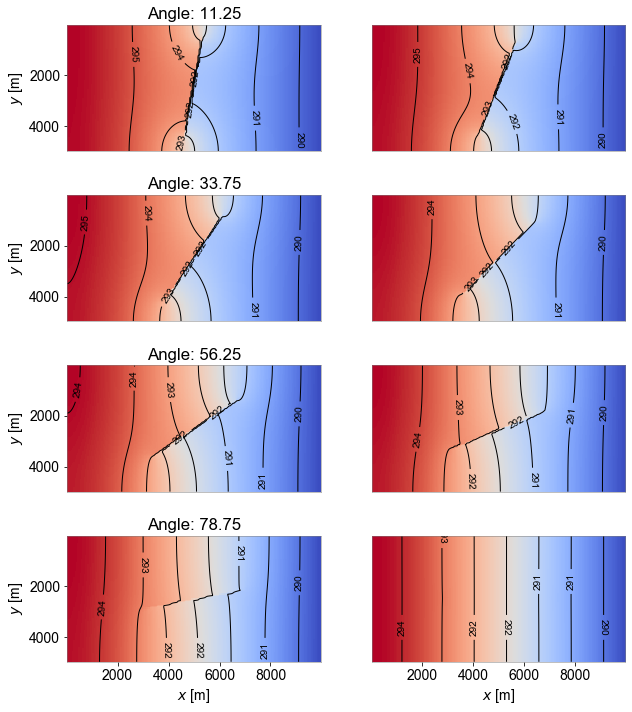

In [188]:
fig = plt.figure(figsize=(10,12)) 

i = 0
for i in range(len(angles)):
    print(angles[i])
    plt.subplot(4,2,(i+1))

    raster = ang_head_rstrs[i][nLayer, :, :]
    extent = (delr/2., Lx - delr/2., Ly - delc/2., delc/2.)

    img = plt.imshow(np.flipud(raster), cmap=head_cmap, extent=extent) 

    plt.ylabel('$y$ [m]')
    plt.xlabel('$x$ [m]')

    axes = plt.gca()

    if (i != 6 and i != 7):
        axes.axes.get_xaxis().set_visible(False)
    else:
        pass
    if (i == 1 or i == 3 or i == 5 or i == 7):
        axes.axes.get_yaxis().set_visible(False)
    else:
        pass
    
    axes.set_title('Angle: %2.2f' %angles[i])


    cs = plt.contour(raster, antialiased = True, extent=extent, colors=contour_colors) 
    plt.clabel(cs, inline=1, fontsize=10, fmt='%1i', colors=contour_colors)

## Then plot age

11.25
22.5
33.75
45
56.25
67.5
78.75
90


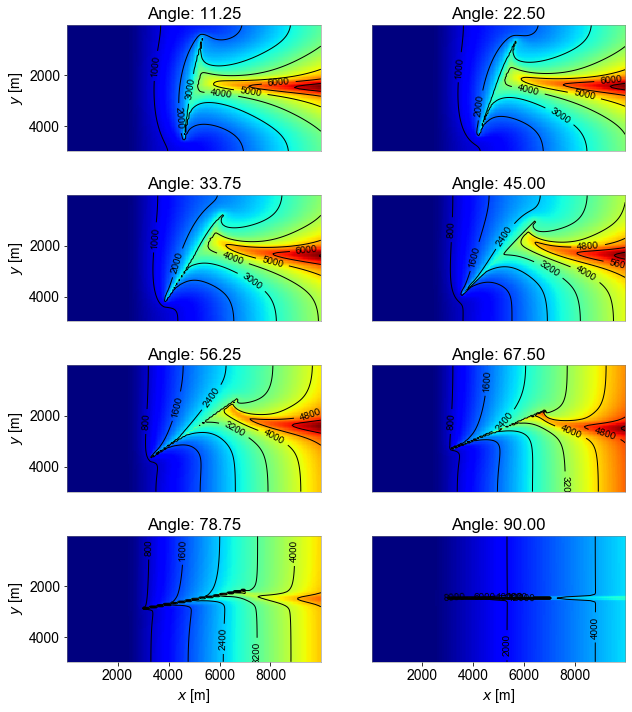

In [187]:
fig = plt.figure(figsize=(10,12)) 

i = 0
for i in range(len(angles)):
    print(angles[i])
    
    plt.subplot(4,2,(i+1))

    raster = ang_age_rstrs[i][nLayer, :, :]
    extent = (delr/2., Lx - delr/2., Ly - delc/2., delc/2.)

    img = plt.imshow(np.flipud(raster), cmap=age_cmap, extent=extent) 

    plt.ylabel('$y$ [m]')
    plt.xlabel('$x$ [m]')

    axes = plt.gca()

    if (i != 6 and i != 7):
        axes.axes.get_xaxis().set_visible(False)
    else:
        pass
    if (i == 1 or i == 3 or i == 5 or i == 7):
        axes.axes.get_yaxis().set_visible(False)
    else:
        pass
    
    axes.set_title('Angle: %2.2f' %angles[i])

    cs = plt.contour(raster, antialiased = True, extent=extent, colors=contour_colors) 
    plt.clabel(cs, inline=1, fontsize=10, fmt='%1i', colors=contour_colors)